In [19]:
from transformers import AutoTokenizer, AutoModelForTokenClassification, TokenClassificationPipeline
from model2 import get_model
import torch

model_name = "QCRI/bert-base-multilingual-cased-pos-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = get_model()


Some weights of the model checkpoint at QCRI/bert-base-multilingual-cased-pos-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [20]:
import nltk
from transformers import AutoTokenizer, AutoModelForTokenClassification
from torch.utils.data import Dataset, DataLoader

# Download the Penn TreeBank dataset
nltk.download('treebank')

[nltk_data] Downloading package treebank to
[nltk_data]     /u/amo-d1/grad/mha361/nltk_data...
[nltk_data]   Unzipping corpora/treebank.zip.


True

In [21]:
from nltk.corpus import treebank

# Load the dataset
sentences = treebank.tagged_sents()


In [26]:
len(sentences)

3914

In [18]:
text = "A test example"
model = model.to("cuda")
inputs = tokenizer(text, return_tensors="pt").to("cuda")
outputs = model(**inputs)
logits = outputs.logits
predictions = torch.argmax(logits, dim=-1)
predictions = predictions.cpu().numpy()

# Convert to labels
label_list = model.config.id2label
labeled_predictions = [label_list[id] for id in predictions[0]]

# Combine tokens and predictions
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
result = list(zip(tokens, labeled_predictions))

print(result)

[('[CLS]', 'NN'), ('A', 'DT'), ('test', 'NN'), ('example', 'NN'), ('[SEP]', 'NN')]


In [8]:
for n,m in model.named_modules():
    print(n)
    # print(m)


bert
bert.embeddings
bert.embeddings.word_embeddings
bert.embeddings.position_embeddings
bert.embeddings.token_type_embeddings
bert.embeddings.LayerNorm
bert.embeddings.dropout
bert.encoder
bert.encoder.layer
bert.encoder.layer.0
bert.encoder.layer.0.attention
bert.encoder.layer.0.attention.self
bert.encoder.layer.0.attention.self.query
bert.encoder.layer.0.attention.self.key
bert.encoder.layer.0.attention.self.value
bert.encoder.layer.0.attention.self.dropout
bert.encoder.layer.0.attention.output
bert.encoder.layer.0.attention.output.dense
bert.encoder.layer.0.attention.output.LayerNorm
bert.encoder.layer.0.attention.output.dropout
bert.encoder.layer.0.intermediate
bert.encoder.layer.0.intermediate.dense
bert.encoder.layer.0.intermediate.intermediate_act_fn
bert.encoder.layer.0.output
bert.encoder.layer.0.output.dense
bert.encoder.layer.0.output.LayerNorm
bert.encoder.layer.0.output.dropout
bert.encoder.layer.1
bert.encoder.layer.1.attention
bert.encoder.layer.1.attention.self
bert.e

In [32]:
import nltk
import torch
import numpy as np
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForTokenClassification, AdamW
from sklearn.metrics import f1_score

# Download the Penn TreeBank dataset
nltk.download('treebank')

from nltk.corpus import treebank

# Load the dataset
sentences = treebank.tagged_sents()

# Split the dataset into train and test sets
train_size = int(0.8 * len(sentences))
train_sentences = sentences[:train_size]
test_sentences = sentences[train_size:]

class PennTreebankDataset(Dataset):
    def __init__(self, sentences, tokenizer, max_length=128):
        self.sentences = sentences
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.tag2id = {tag: i for i, tag in enumerate(set([tag for sent in self.sentences for _, tag in sent]))}
        self.id2tag = {i: tag for tag, i in self.tag2id.items()}

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        sentence, tags = zip(*self.sentences[idx])
        sentence = " ".join(sentence)
        
        encoding = self.tokenizer(sentence, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        
        # Align tags with tokenized words
        aligned_tags = []
        words = self.tokenizer.tokenize(sentence)
        for word, tag in zip(sentence.split(), tags):
            tokens = self.tokenizer.tokenize(word)
            aligned_tags.extend([tag] * len(tokens))
        
        # Pad or truncate tags to match input_ids length
        if len(aligned_tags) > self.max_length - 2:
            aligned_tags = aligned_tags[:self.max_length - 2]
        
        # Add tags for [CLS] and [SEP]
        aligned_tags = [aligned_tags[0]] + aligned_tags + [aligned_tags[-1]]
        
        # Pad with the last tag if necessary
        aligned_tags += [aligned_tags[-1]] * (self.max_length - len(aligned_tags))
        
        # Convert tags to IDs
        tag_ids = [self.tag2id[tag] for tag in aligned_tags]
        
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(tag_ids)
        }
# Set up the model and tokenizer
model_name = "QCRI/bert-base-multilingual-cased-pos-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForTokenClassification.from_pretrained(model_name)

# Create datasets and dataloaders
train_dataset = PennTreebankDataset(train_sentences, tokenizer)
test_dataset = PennTreebankDataset(test_sentences, tokenizer)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16)

# Training setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = AdamW(model.parameters(), lr=5e-5)

# Training loop
num_epochs = 3
for epoch in range(num_epochs):
    model.train()
    for batch in tqdm(train_dataloader, desc=f"Training Epoch {epoch+1}"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# Evaluation and F1 score calculation
model.eval()
all_predictions = []
all_labels = []

with torch.no_grad():
    for batch in tqdm(test_dataloader, desc="Evaluating"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        
        # Remove padding and special tokens
        for pred, label, mask in zip(predictions, labels, attention_mask):
            pred = pred[mask.bool()][1:-1]
            label = label[mask.bool()][1:-1]
            all_predictions.extend(pred.cpu().numpy())
            all_labels.extend(label.cpu().numpy())

# Calculate F1 score
f1 = f1_score(all_labels, all_predictions, average='weighted')
print(f"Weighted F1 Score: {f1:.4f}")

# Print classification report
from sklearn.metrics import classification_report
print("\nClassification Report:")
print(classification_report(all_labels, all_predictions, target_names=list(train_dataset.tag2id.keys())))

[nltk_data] Downloading package treebank to
[nltk_data]     /u/amo-d1/grad/mha361/nltk_data...
[nltk_data]   Package treebank is already up-to-date!
/u/amo-d1/grad/mha361/anaconda3/envs/memit/lib/python3.9/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of the model checkpoint at QCRI/bert-base-multilingual-cased-pos-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPr

Weighted F1 Score: 0.1134

Classification Report:
              precision    recall  f1-score   support

          RP       0.69      0.85      0.76        34
         JJS       0.90      0.98      0.94        45
          RB       0.95      0.98      0.97       630
          TO       1.00      1.00      1.00       464
         JJR       0.92      0.95      0.94        84
          IN       0.99      0.98      0.99      1953
         PDT       0.00      0.00      0.00         6
         SYM       0.00      0.00      0.00        28
         WRB       0.00      0.00      0.00       602
          LS       0.00      0.00      0.00       104
         VBN       0.00      0.00      0.00       597
       -RRB-       0.00      0.00      0.00       388
          VB       0.00      0.00      0.00      1768
         VBZ       0.00      0.00      0.00      3741
          JJ       0.00      0.00      0.00       930
           ,       0.00      0.00      0.00       106
          NN       0.00      0.

/u/amo-d1/grad/mha361/anaconda3/envs/memit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/u/amo-d1/grad/mha361/anaconda3/envs/memit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/u/amo-d1/grad/mha361/anaconda3/envs/memit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg

In [41]:
import nltk
from nltk.corpus import treebank
from transformers import AutoTokenizer, AutoModelForTokenClassification
import torch
from transformers import pipeline
from sklearn.metrics import classification_report

# Download the treebank dataset
nltk.download('treebank')

# Load the model and tokenizer
model_name = "QCRI/bert-base-multilingual-cased-pos-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForTokenClassification.from_pretrained(model_name)

# Get the tag set and label mapping
label_list = model.config.id2label

# Load the dataset
sentences = treebank.tagged_sents()

[nltk_data] Downloading package treebank to
[nltk_data]     /u/amo-d1/grad/mha361/nltk_data...
[nltk_data]   Package treebank is already up-to-date!
Some weights of the model checkpoint at QCRI/bert-base-multilingual-cased-pos-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [47]:
from torch.utils import data
class PosDataset(data.Dataset):
    def __init__(self, tagged_sents,tokenizer,tag2idx,idx2tag):
        sents, tags_li = [], [] # list of lists
        self.tokenizer = tokenizer
        self.tag2idx = tag2idx
        self.idx2tag = idx2tag
        for sent in tagged_sents:
            words = [word_pos[0] for word_pos in sent]
            tags = [word_pos[1] for word_pos in sent]
            sents.append(["[CLS]"] + words + ["[SEP]"])
            tags_li.append(["<pad>"] + tags + ["<pad>"])
        self.sents, self.tags_li = sents, tags_li

    def __len__(self):
        return len(self.sents)

    def __getitem__(self, idx):
        words, tags = self.sents[idx], self.tags_li[idx] # words, tags: string list

        # We give credits only to the first piece.
        x, y = [], [] # list of ids
        is_heads = [] # list. 1: the token is the first piece of a word
        for w, t in zip(words, tags):
            tokens = self.tokenizer.tokenize(w) if w not in ("[CLS]", "[SEP]") else [w]
            xx = self.tokenizer.convert_tokens_to_ids(tokens)

            is_head = [1] + [0]*(len(tokens) - 1)

            t = [t] + ["<pad>"] * (len(tokens) - 1)  # <PAD>: no decision
            yy = [self.tag2idx[each] for each in t]  # (T,)

            x.extend(xx)
            is_heads.extend(is_head)
            y.extend(yy)

        assert len(x)==len(y)==len(is_heads), "len(x)={}, len(y)={}, len(is_heads)={}".format(len(x), len(y), len(is_heads))

        # seqlen
        seqlen = len(y)

        # to string
        words = " ".join(words)
        tags = " ".join(tags)
        return words, x, is_heads, tags, y, seqlen

In [48]:
tagged_sents = treebank.tagged_sents()
print(len(tagged_sents))
print(tagged_sents[0])
tags = list(set(word_pos[1] for sent in tagged_sents for word_pos in sent))
tags = ["<pad>"] + tags
tags_str = ','.join(tags)
print(len(tags_str))
print(tags_str)
tag2idx = {tag:idx for idx, tag in enumerate(tags)}
idx2tag = {idx:tag for idx, tag in enumerate(tags)}
dataset = PosDataset(sentences,tokenizer,tag2idx,idx2tag)

3914
[('Pierre', 'NNP'), ('Vinken', 'NNP'), (',', ','), ('61', 'CD'), ('years', 'NNS'), ('old', 'JJ'), (',', ','), ('will', 'MD'), ('join', 'VB'), ('the', 'DT'), ('board', 'NN'), ('as', 'IN'), ('a', 'DT'), ('nonexecutive', 'JJ'), ('director', 'NN'), ('Nov.', 'NNP'), ('29', 'CD'), ('.', '.')]
170
<pad>,RP,JJS,RB,TO,JJR,IN,PDT,SYM,WRB,LS,VBN,-RRB-,VB,VBZ,JJ,,,NN,:,-LRB-,``,NNPS,#,PRP$,NNS,$,EX,WDT,VBD,PRP,VBG,.,UH,POS,'',RBR,MD,CD,CC,VBP,-NONE-,FW,WP$,NNP,WP,RBS,DT


In [69]:
from tqdm import tqdm
true_labels = []
pred_labels = []
model.eval()
with torch.no_grad():
    for words, x, is_heads, tags, y, seqlen in tqdm(dataset):
        
        x = torch.tensor(x).unsqueeze(0)
        outputs = model(x).logits
        predictions = torch.argmax(outputs, dim=2).squeeze().tolist()
        
        

  0%|          | 0/3914 [00:38<?, ?it/s]


KeyboardInterrupt: 

In [65]:
true_labels[0]

['<',
 'p',
 'a',
 '>',
 ' ',
 'N',
 'N',
 'P',
 ' ',
 'N',
 'N',
 'P',
 ' ',
 ',',
 ' ',
 'N',
 'N',
 ' ',
 'J',
 'J']

In [66]:
pred_labels[0]

['.',
 'NNP',
 'NNP',
 ',',
 'CD',
 'NNS',
 'JJ',
 ',',
 'MD',
 'VB',
 'DT',
 'NN',
 'IN',
 'DT',
 'JJ',
 'NN',
 'NNP',
 'CD',
 '.',
 '.']

In [1]:
from datasets import load_dataset, concatenate_datasets

from sklearn.model_selection import train_test_split
from transformers import GPT2Tokenizer, DataCollatorForLanguageModeling
import random
import numpy as np
from utilities import evaluate_gpt2_classification as evaluate_gpt2_classification, mask_range_gpt,compute_masks, reset_gpt, compute_mask_probe
import torch  
from tqdm import tqdm

dataset_name = "dair-ai/emotion"

text_tag = "text"

# Load dataset and tokenizer


tables = []
layer = 11
# for i in tqdm(range(1, 21)):
per = 0.3
print("Percentage: ", per)
num_classes = 6

# tao = 2.5

lab = "label"
# tao = torch.inf

dataset = load_dataset(dataset_name)

print(dataset)
# Set random seed
seed_value = 42  # or any other integer

random.seed(seed_value)
np.random.seed(seed_value)

if torch.cuda.is_available():  # PyTorch-specific
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

import torch

torch.autograd.set_detect_anomaly(True)
# Load tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')


special_tokens_dict = {}
new_tokens = []
label2text = dataset['train'].features[lab].names

for label in label2text:
    # Create special token format (with and without space)
    special_token = f'{label}'
    
    # Check if the label is already a single token in the tokenizer
    label_tokens = tokenizer.encode(label, add_special_tokens=False)
    is_single_token = len(label_tokens) == 1
    
    if is_single_token:
        print(f"'{label}' is already a single token (ID: {label_tokens[0]})")
    
    # Add both versions to new tokens list
    new_tokens.extend([special_token])

# Add the tokens to the tokenizer
num_added_tokens = tokenizer.add_tokens(new_tokens)
print(f"\nAdded {num_added_tokens} new tokens to the tokenizer")

special_tokens = {
    'pad_token': '<|pad|>',
    'sep_token': '<|sep|>',
    'eos_token': '<|eos|>'
}
tokenizer.add_special_tokens(special_tokens)

def format_data(examples):
    formatted_texts = []
    for text, label in zip(examples[text_tag], examples[lab]):
        # Convert label to string
        
        tok_text = tokenizer.encode(text, max_length=400, truncation=True)
        text = tokenizer.decode(tok_text)
        label_str = dataset['train'].features[lab].int2str(label)
        formatted_text = f"Classify emotion: {text}{tokenizer.sep_token}"#{label_str}{tokenizer.eos_token}"
        formatted_texts.append(formatted_text)
    return {'formatted_text': formatted_texts}

def tokenize_and_prepare(examples):

    # Tokenize with batch processing
    tokenized = tokenizer(
        examples['formatted_text'],
        padding='max_length',
        max_length=408,
        truncation=True,
        return_tensors="pt"
    )
    
    # Clone input_ids to create labels
    labels = tokenized['input_ids'].clone()
    
    # Find the position of sep_token
    sep_token_id = tokenizer.convert_tokens_to_ids(tokenizer.sep_token)
    sep_positions = (labels == sep_token_id).nonzero(as_tuple=True)
    
    # Mask all tokens with -100 except for the token right after sep_token
    labels[:] = -100  # Mask all initially
    for batch_idx, sep_pos in zip(*sep_positions):
        if sep_pos + 1 < labels.size(1):
            labels[batch_idx, sep_pos + 1] = tokenized['input_ids'][batch_idx, sep_pos + 1]
    
    # Set padding tokens to -100
    labels[labels == tokenizer.pad_token_id] = -100
    
    return {
        'input_ids': tokenized['input_ids'],
        'attention_mask': tokenized['attention_mask'],
        'labels': labels
    }
# Process the dataset
formatted_dataset = dataset.map(format_data, batched=True)
tokenized_dataset = formatted_dataset.map(
    tokenize_and_prepare, 
    batched=True,
)

from transformers import GPT2LMHeadModel as gt
from models.gpt2 import GPT2LMHeadModel
# Load pre-trained GPT-2 model
model1 = gt.from_pretrained('gpt2')

model1.resize_token_embeddings(len(tokenizer))

model1.config.m_layer = layer
import os

base_path = os.path.join("model_weights", dataset_name)
if not os.path.exists(base_path):
    os.makedirs(base_path)

weights_path = os.path.join(base_path, "weights.pth")

model = GPT2LMHeadModel(model1.config)


model.load_state_dict(torch.load(weights_path))




from prettytable import PrettyTable
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.tensor")

batch_size = 2048/2
# mask_layer = 5
compliment = True
results_table = PrettyTable()
if(compliment):
    results_table.field_names = results_table.field_names = ["Class", "Base Accuracy", "Base Confidence", "Base Complement Acc", "Base Compliment Conf", "STD Accuracy", "STD Confidence", "STD compliment ACC", "STD compliment Conf", "MAX Accuracy", "MAX Confidence", "Max compliment acc", "Max compliment conf", "Total Masked", "Intersection"]#, "Same as Max"]#"MAX Accuracy", "MAX Confidence", "Max compliment acc", "Max compliment conf"

class_labels = []
base_accuracies = []
base_confidences = []
base_comp_acc = []
base_comp_conf = []
std_masked_counts = []
std_accuracies = []
std_confidences = []
std_comp_acc = []
std_comp_conf = []
max_masked_counts = []
max_accuracies = []
max_confidences = []
max_comp_acc = []
max_comp_conf = []
diff_from_max = []
total_masked = []

#merge test and train set and then shuffle and make splits

# First merge and shuffle
tokenized_dataset = concatenate_datasets([tokenized_dataset['train'], tokenized_dataset['test']]).shuffle(seed=42)

# Get the total length
dataset_length = len(tokenized_dataset)

# Calculate split index
split_index = int(dataset_length * 0.2)  # 80% for training

# Create the splits using dataset slicing
tokenized_dataset1 = tokenized_dataset.select(range(split_index))  # training set
recording_dataset = tokenized_dataset.select(range(split_index, dataset_length))

all_fc_vals = []
print("Recording activations...")
for j in range(0,num_classes):
    dataset_recording = recording_dataset.filter(lambda x: x[lab] in [j])
    fc_vals = evaluate_gpt2_classification(lab, model, dataset_recording, tokenizer)
    fc_vals = fc_vals[2]
    all_fc_vals.append(fc_vals)
    
# save all_fc_vals to file
import pickle

# with open('all_fc_vals.pkl', 'wb') as f:
#     pickle.dump(all_fc_vals, f)
    
# # # Load all_fc_vals from file
# # with open('all_fc_vals.pkl', 'rb') as f:
# #     all_fc_vals = pickle.load(f)





Percentage:  0.3
DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})


/u/amo-d1/grad/mha361/anaconda3/envs/memit/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


'joy' is already a single token (ID: 2633)
'love' is already a single token (ID: 23205)
'anger' is already a single token (ID: 2564)

Added 3 new tokens to the tokenizer


/tmp/ipykernel_3124760/3613369107.py:149: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weights_path))


Recording activations...


Evaluating:   0%|          | 0/132 [00:00<?, ?it/s]

/mounts/u-amo-d1/grad/mha361/work/probless/Sentiment/utilities.py:664: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(item['input_ids']).to(device)
/mounts/u-amo-d1/grad/mha361/work/probless/Sentiment/utilities.py:665: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attention_mask = torch.tensor(item['attention_mask']).to(device)


Evaluating:   0%|          | 0/152 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/37 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/54 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

In [ ]:
import importlib 
import utilities  # import the entire module
importlib.reload(utilities)
from utilities import compute_masks
for i in range(1, 21):
    per = 0.05 * i
    print(f"\nAnalysis for Percentage: {per:.2f}")
    
    # Create table for this percentage
    table = PrettyTable()
    table.field_names = ["Class", "Total Masked", "Common Zeros", "Common Zeros %"]
    
    for j in range(0, num_classes):
        # Compute masks
        mask_max, mask_std, mask_intersection, mask_max_low_std, \
        mask_max_high_std, mask_std_high_max, mask_max_random_off, \
        random_mask = compute_masks(all_fc_vals[j], per)
        
        # Calculate intersections and zeros
        intersection_zeros = (~mask_std.bool()) & (~mask_max.bool())
        num_common_zeros = intersection_zeros.sum().item()
        total_masked = int(mask_std.shape[0] - torch.count_nonzero(mask_std))
        percentage_common_zeros = num_common_zeros / total_masked
        
        # Add row to table
        table.add_row([
            j,
            total_masked,
            num_common_zeros,
            f"{percentage_common_zeros:.4f}"
        ])
    
    print(table)
    print("-" * 50)  # Separator between tables
    


Analysis for Percentage: 0.05
+-------+--------------+--------------+----------------+
| Class | Total Masked | Common Zeros | Common Zeros % |
+-------+--------------+--------------+----------------+
|   0   |      38      |      12      |     0.3158     |
|   1   |      38      |      9       |     0.2368     |
|   2   |      38      |      8       |     0.2105     |
|   3   |      38      |      9       |     0.2368     |
|   4   |      38      |      10      |     0.2632     |
|   5   |      38      |      14      |     0.3684     |
+-------+--------------+--------------+----------------+
--------------------------------------------------

Analysis for Percentage: 0.10
+-------+--------------+--------------+----------------+
| Class | Total Masked | Common Zeros | Common Zeros % |
+-------+--------------+--------------+----------------+
|   0   |      76      |      18      |     0.2368     |
|   1   |      76      |      19      |     0.2500     |
|   2   |      76      |      23

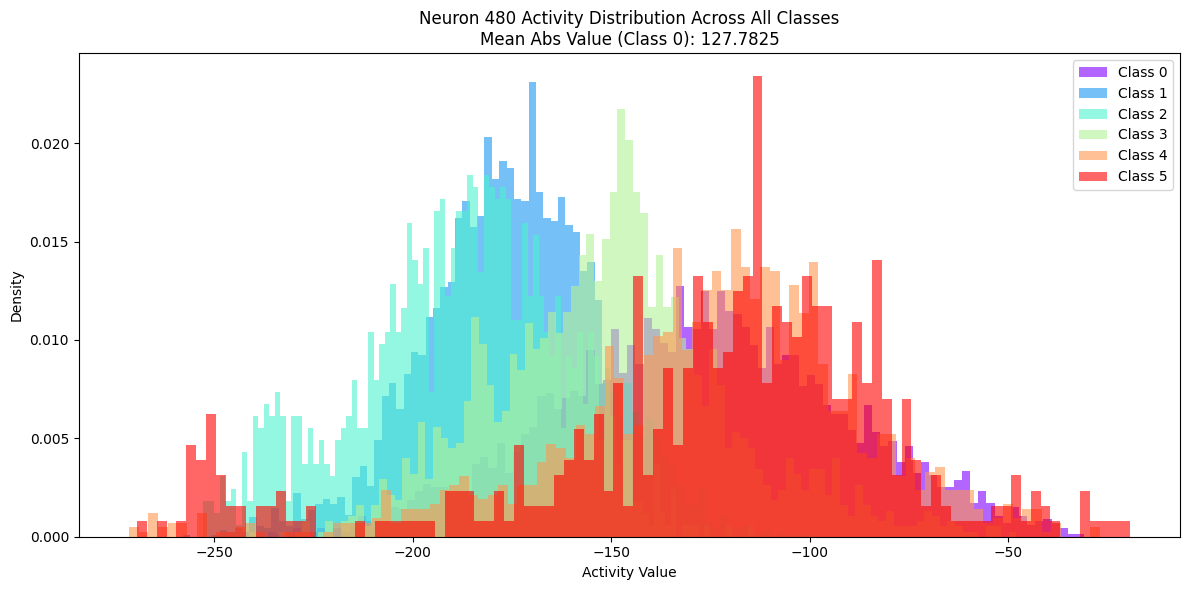

In [37]:
import numpy as np
import matplotlib.pyplot as plt

# Get mean absolute values for neurons from first class to select the neuron
fc_class0 = np.array(all_fc_vals[0])
mean_class0 = np.mean(np.abs(fc_class0), axis=0)

# Sort neurons based on class 0 mean absolute values
sorted_neurons = np.argsort(mean_class0)

# Select one of the top neurons (using the highest mean abs value neuron)
selected_neuron = 480#64,  87, 120, 232, 266, 373, 447, 480, 481

# Create figure
plt.figure(figsize=(12, 6))

# Colors for different classes
colors = plt.cm.rainbow(np.linspace(0, 1, len(all_fc_vals)))

# Plot distribution for each class
for class_idx, fc_class in enumerate(all_fc_vals):
    fc = np.array(fc_class)
    dist = [n[selected_neuron] for n in fc]
    
    plt.hist(dist, bins=100, density=True, alpha=0.6, 
             color=colors[class_idx], label=f'Class {class_idx}')

# Add title and labels
plt.title(f'Neuron {selected_neuron} Activity Distribution Across All Classes\n' + 
         f'Mean Abs Value (Class 0): {mean_class0[selected_neuron]:.4f}')
plt.xlabel('Activity Value')
plt.ylabel('Density')
plt.legend()

# Adjust layout
plt.tight_layout()

# Save figure
plt.savefig(f"neuron_{selected_neuron}_all_classes.pdf", format="pdf", bbox_inches='tight', dpi=1200)

# Show plot
plt.show()

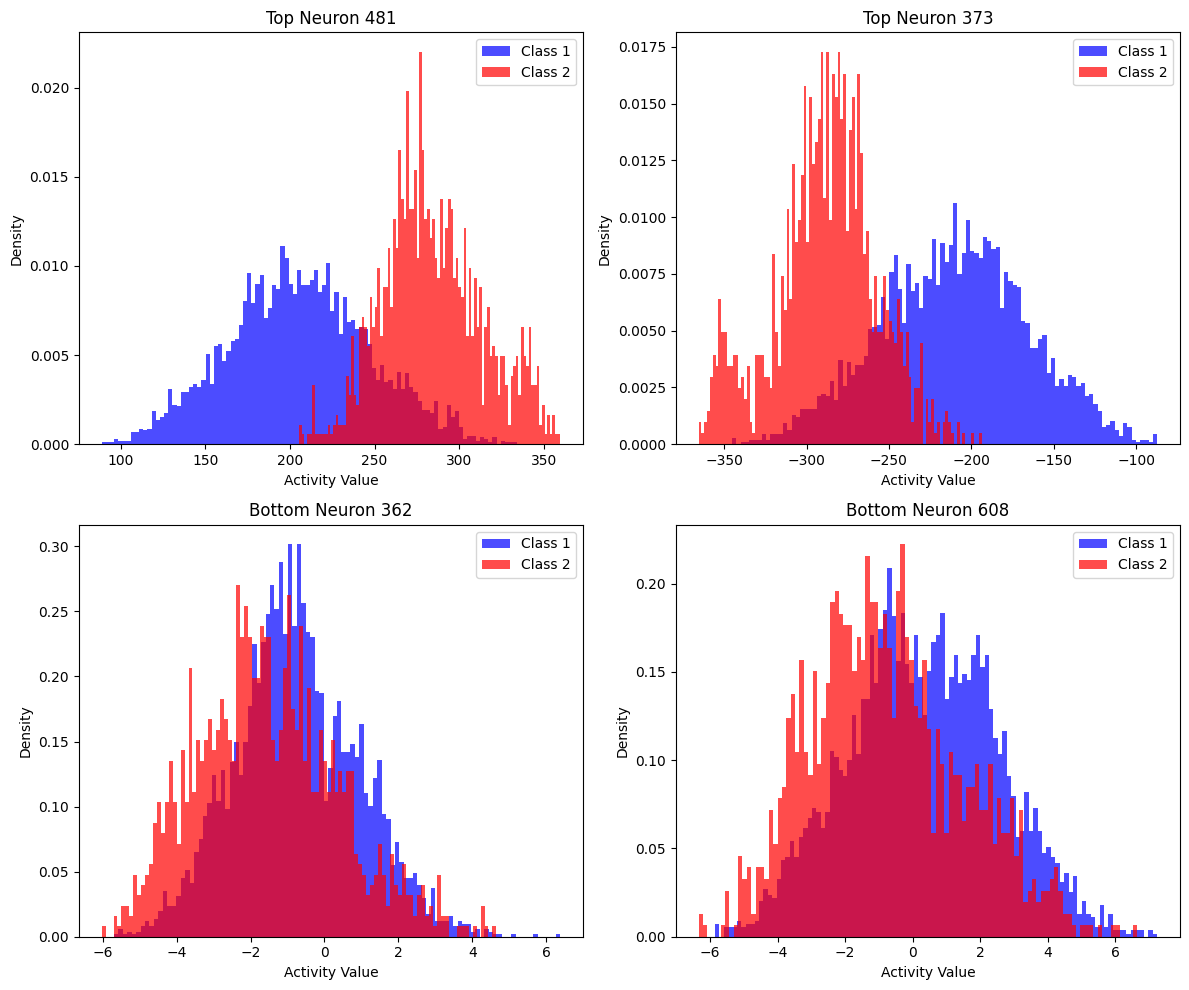

In [42]:
import numpy as np
import matplotlib.pyplot as plt

# Get mean absolute values for neurons from first class
fc_class1 = np.array(all_fc_vals[0])
mean_class1 = np.mean(np.abs(fc_class1), axis=0)

# Sort neurons based on class 1 mean absolute values
sorted_neurons = np.argsort(mean_class1)

# Get indices for top 2 and bottom 2 neurons
top_neurons = sorted_neurons[-2:]  # Top 2
bottom_neurons = sorted_neurons[:2]  # Bottom 2
selected_neurons = np.concatenate([top_neurons, bottom_neurons])

# Get activations for class 2
fc_class2 = np.array(all_fc_vals[2])

# Create figure with 2x2 subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs = axs.ravel()

# Plot distributions for each selected neuron
for idx, neuron_idx in enumerate(selected_neurons):
    # Get distributions for both classes
    dist_class1 = [n[neuron_idx] for n in fc_class1]
    dist_class2 = [n[neuron_idx] for n in fc_class2]
    
    # Create histograms for both classes
    axs[idx].hist(dist_class1, bins=100, density=True, alpha=0.7, color='blue', label='Class 1')
    axs[idx].hist(dist_class2, bins=100, density=True, alpha=0.7, color='red', label='Class 2')
    
    # Add title indicating neuron index and whether it's top/bottom
    if idx < 2:
        title = f"Top Neuron {neuron_idx}"
    else:
        title = f"Bottom Neuron {neuron_idx}"
    axs[idx].set_title(title)
    
    # Add labels and legend
    axs[idx].set_xlabel('Activity Value')
    axs[idx].set_ylabel('Density')
    axs[idx].legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Save figure
plt.savefig("multiple_neuron_dist_two_classes.pdf", format="pdf", bbox_inches='tight', dpi=600)

# Show plot
plt.show()

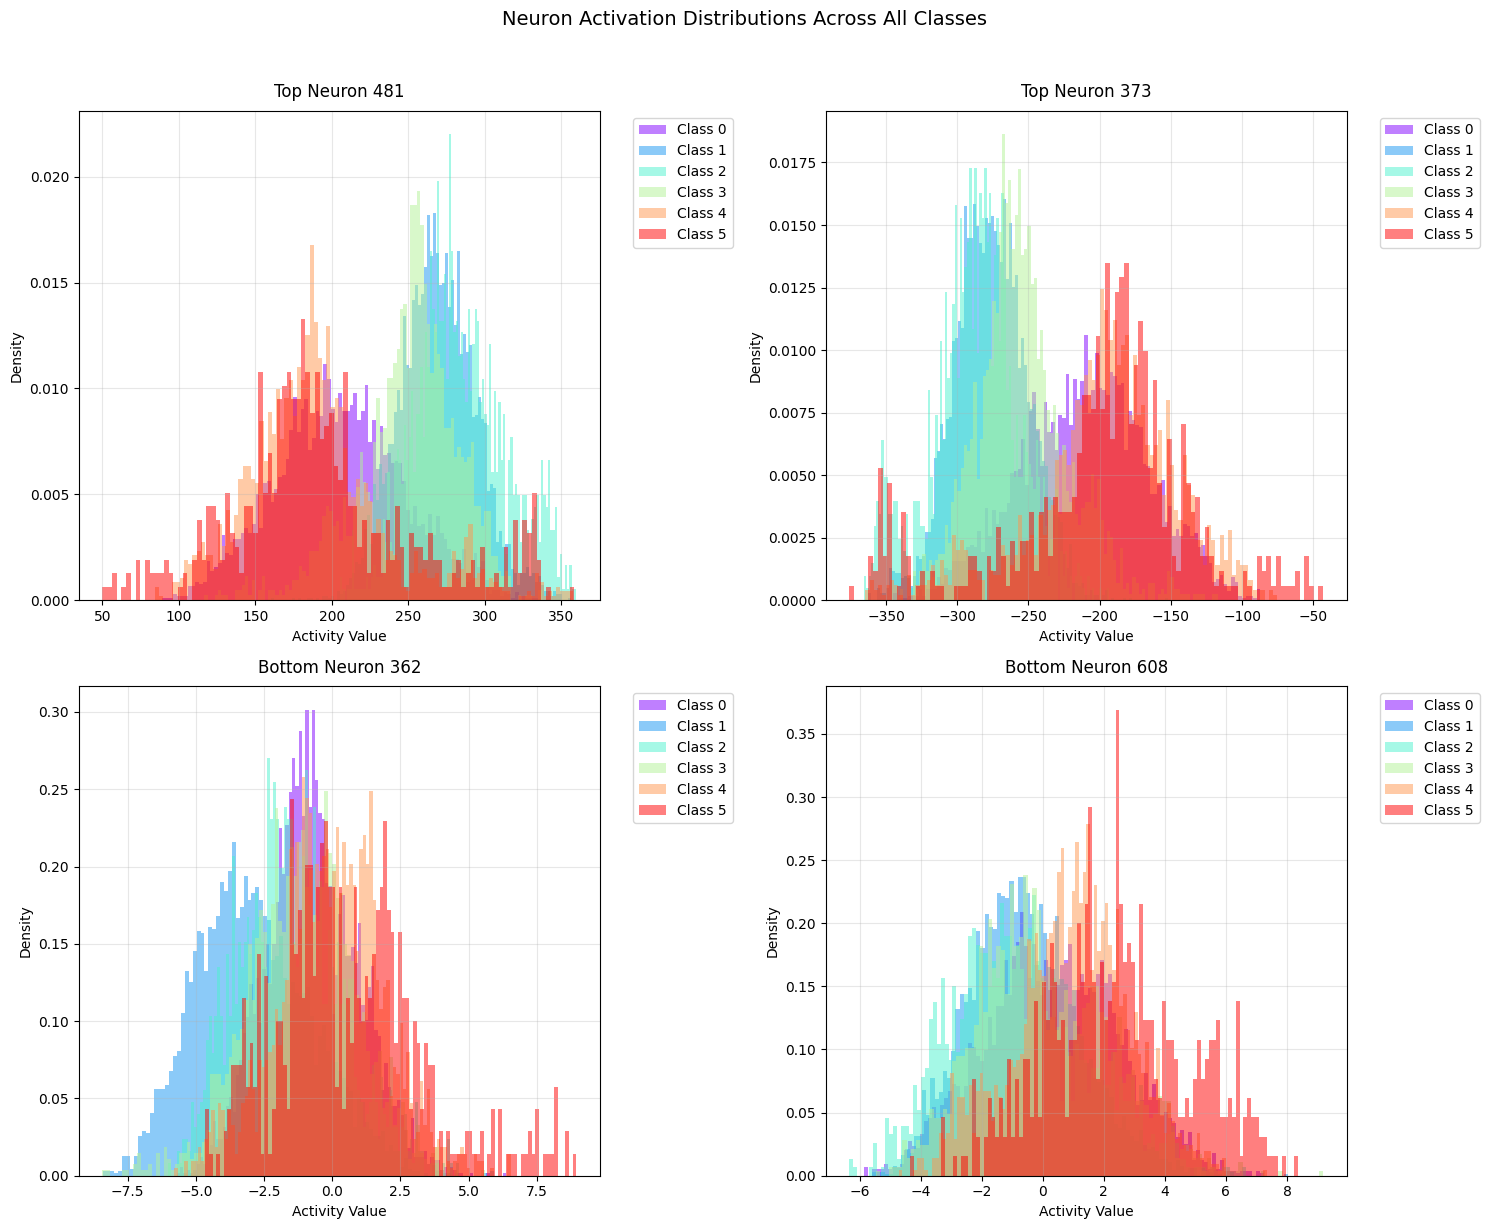

In [40]:
import numpy as np
import matplotlib.pyplot as plt

# Get mean absolute values for neurons from first class
fc_class1 = np.array(all_fc_vals[0])
mean_class1 = np.mean(np.abs(fc_class1), axis=0)

# Sort neurons based on class 1 mean absolute values
sorted_neurons = np.argsort(mean_class1)

# Get indices for top 2 and bottom 2 neurons
top_neurons = sorted_neurons[-2:]  # Top 2
bottom_neurons = sorted_neurons[:2]  # Bottom 2
selected_neurons = np.concatenate([top_neurons, bottom_neurons])

# Create figure with 2x2 subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 12))
axs = axs.ravel()

# Define colors for each class
num_classes = len(all_fc_vals)
colors = plt.cm.rainbow(np.linspace(0, 1, num_classes))

# Plot distributions for each selected neuron
for idx, neuron_idx in enumerate(selected_neurons):
    # Plot distributions for all classes
    for class_idx in range(num_classes):
        # Get current class data
        class_data = np.array(all_fc_vals[class_idx])
        dist_class = [n[neuron_idx] for n in class_data]
        
        # Create histogram for current class
        axs[idx].hist(dist_class, 
                     bins=100, 
                     density=True, 
                     alpha=0.5, 
                     color=colors[class_idx], 
                     label=f'Class {class_idx}')
    
    # Add title indicating neuron index and whether it's top/bottom
    if idx < 2:
        title = f"Top Neuron {neuron_idx}"
    else:
        title = f"Bottom Neuron {neuron_idx}"
    axs[idx].set_title(title, fontsize=12, pad=10)
    
    # Add labels and legend
    axs[idx].set_xlabel('Activity Value', fontsize=10)
    axs[idx].set_ylabel('Density', fontsize=10)
    axs[idx].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Add grid for better readability
    axs[idx].grid(True, alpha=0.3)

# Add overall title
fig.suptitle('Neuron Activation Distributions Across All Classes', 
             fontsize=14, 
             y=1.02)

# Adjust layout to prevent overlap
plt.tight_layout()

# Save figure with high resolution
plt.savefig("multiple_neuron_dist_all_classes.pdf", 
            format="pdf", 
            bbox_inches='tight', 
            dpi=600)

# Show plot
plt.show()

In [2]:
mask_all = []
for fc_vals in all_fc_vals:
    mask_max, mask_std, mask_intersection, mask_max_low_std, mask_max_high_std, mask_std_high_max,mask_max_random_off, mask_random = compute_masks(fc_vals, 0.3)
    
    mask_all.append(~mask_max.bool().numpy())

In [ ]:
# Create a heatmap

import seaborn as sns

activation_mask = np.array(mask_all)
pairwise_overlap = np.dot(activation_mask.T, activation_mask)
plt.figure(figsize=(8, 6))
sns.heatmap(
    pairwise_overlap, 
    annot=True,  # Show the values in the heatmap cells
    cmap='Blues',  # Color map
    cbar=True,     # Display the color bar
    xticklabels=[f'Neuron {i+1}'for i in range(pairwise_overlap.shape[1])],
    yticklabels=[f'Class {i+1}'for i in range(pairwise_overlap.shape[0])],
    linewidths=0.5
)
 
# Add labels and title
plt.xlabel('Neurons')
plt.ylabel('Classes')
plt.title('Neuron Activation Mask for Different Classes')
 
# Show the heatmap
plt.show()

KeyboardInterrupt: 

Creating combined plot...


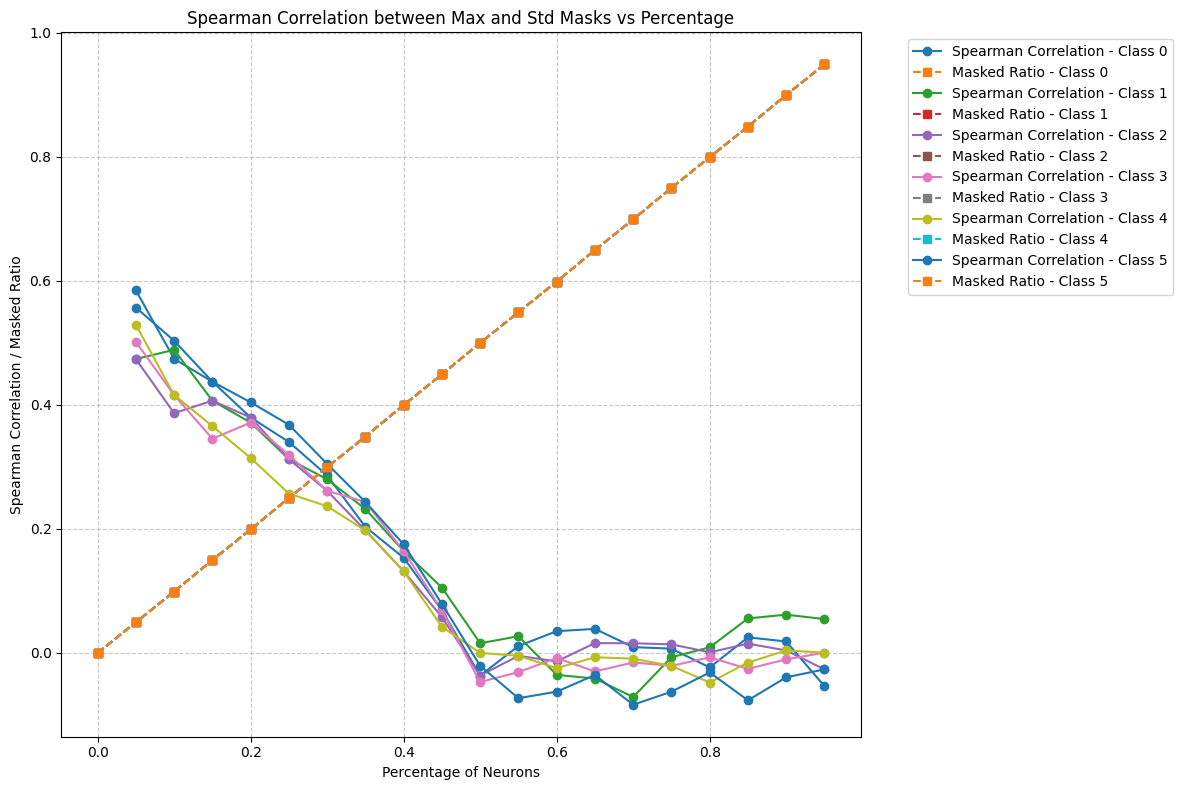


Creating individual class plots...


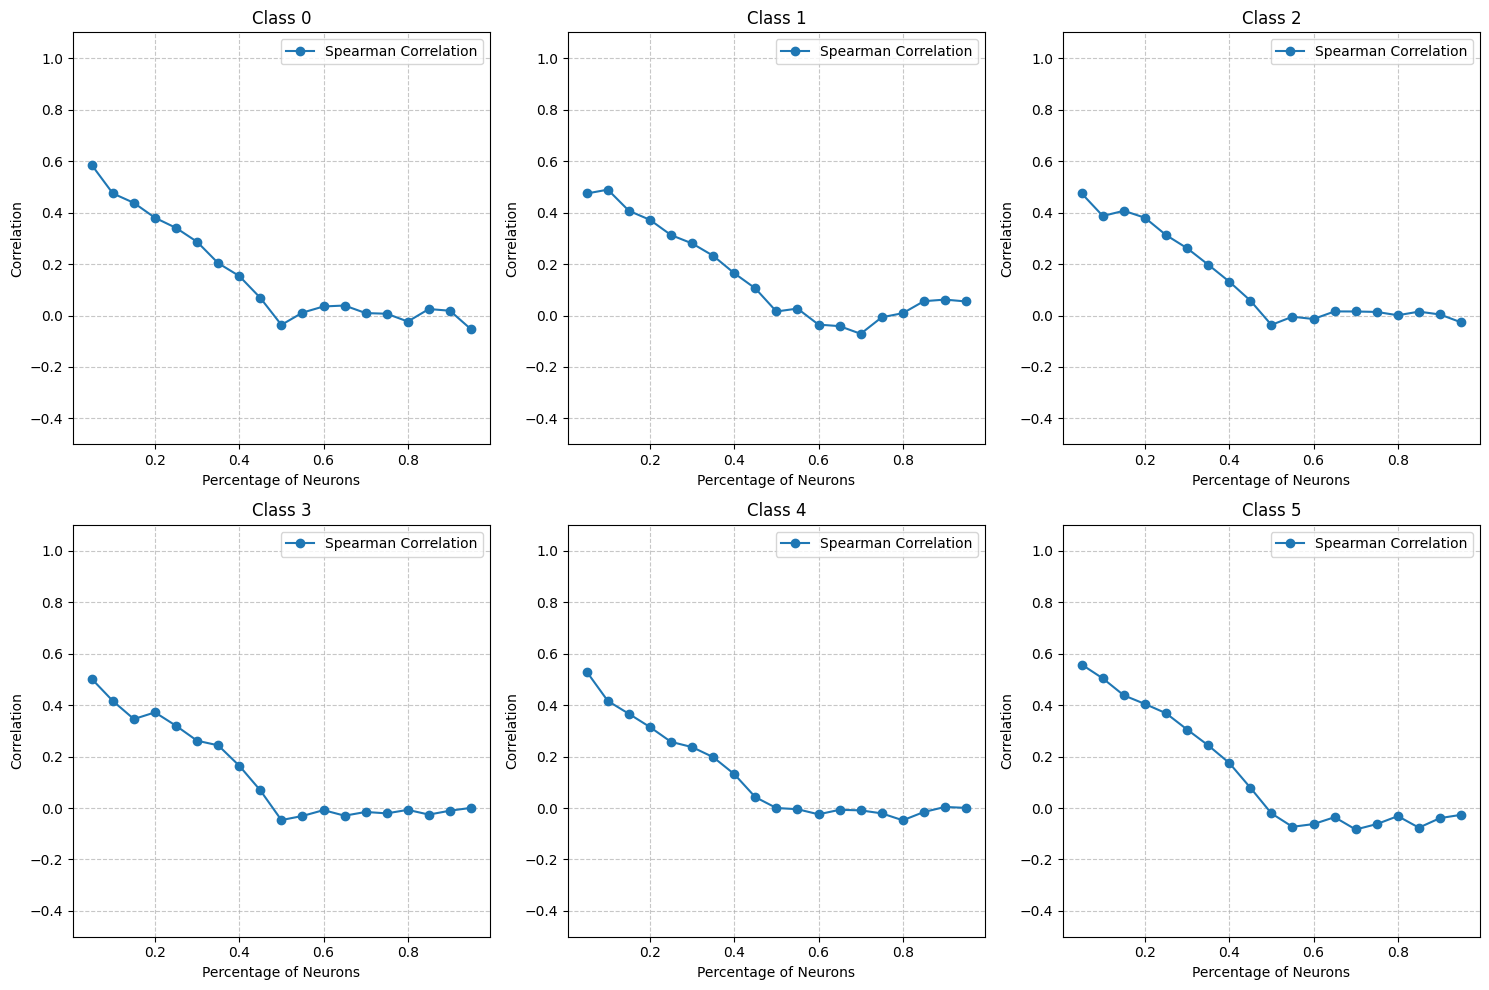


Detailed Statistics:

Class 0:
Max Correlation: nan at 0.05
Min Correlation: nan at 0.05
Mean Correlation: nan
Std Correlation: nan
Final Masked Ratio: 0.949

Class 1:
Max Correlation: nan at 0.05
Min Correlation: nan at 0.05
Mean Correlation: nan
Std Correlation: nan
Final Masked Ratio: 0.949

Class 2:
Max Correlation: nan at 0.05
Min Correlation: nan at 0.05
Mean Correlation: nan
Std Correlation: nan
Final Masked Ratio: 0.949

Class 3:
Max Correlation: nan at 0.05
Min Correlation: nan at 0.05
Mean Correlation: nan
Std Correlation: nan
Final Masked Ratio: 0.949

Class 4:
Max Correlation: nan at 0.05
Min Correlation: nan at 0.05
Mean Correlation: nan
Std Correlation: nan
Final Masked Ratio: 0.949

Class 5:
Max Correlation: nan at 0.05
Min Correlation: nan at 0.05
Mean Correlation: nan
Std Correlation: nan
Final Masked Ratio: 0.949


{0: {'spearman_correlation': [nan,
   0.5847152126892573,
   0.474292668086401,
   0.4375124841866968,
   0.37969073808385145,
   0.3402777777777777,
   0.2862453531598513,
   0.20334328358208956,
   0.15346188359818266,
   0.0685168054270737,
   -0.03645833333333334,
   0.011149768512177083,
   0.035121400338791645,
   0.03879133732148312,
   0.009407724491523373,
   0.006944444444444443,
   -0.023393544566183002,
   0.025174529299767292,
   0.01847501268630067,
   -0.05349794238683128],
  'total_masked': [0,
   38,
   76,
   115,
   153,
   192,
   230,
   268,
   307,
   345,
   384,
   422,
   460,
   499,
   537,
   576,
   614,
   652,
   691,
   729],
  'total_neurons': 768},
 1: {'spearman_correlation': [nan,
   0.473972602739726,
   0.48889564952844533,
   0.4068313469605166,
   0.3715287741112706,
   0.31249999999999994,
   0.28003879101341517,
   0.232,
   0.16431493637256492,
   0.10535512385651145,
   0.015625000000000003,
   0.02692929348272745,
   -0.03534726143421795,
 

In [17]:
import importlib 

import plot_correlation  # import the entire module
importlib.reload(plot_correlation)
from plot_correlation import create_correlation_plots
create_correlation_plots(all_fc_vals, num_classes)

In [122]:
all_fc_vals.append([val for sublist in all_fc_vals for val in sublist])

In [168]:
import utilities
importlib.reload(utilities)
from utilities import compute_avg_std, compute_masks
for fc_vals in all_fc_vals:
    mask_max, mask_std, mask_intersection, mask_max_low_std, mask_max_high_std, mask_std_high_max,mask_max_random_off, mask_random = compute_masks(fc_vals, 0.2)
    
    print("Average: ", compute_avg_std(fc_vals,~mask_max_low_std.bool()))

Average:  5.48443
Average:  5.6513147
Average:  5.146653
Average:  6.6799574
Average:  8.059241
Average:  8.340233
Average:  6.6965027


In [163]:
from utilities import compute_avg_std, compute_masks
for fc_vals in all_fc_vals:
    mask_max, mask_std, mask_intersection, mask_max_low_std, mask_max_high_std, mask_std_high_max,mask_max_random_off, mask_random = compute_masks(fc_vals, 0.2)
    
    print("Average: ", compute_avg_std(fc_vals,~mask_max.bool()))

Average:  7.18825
Average:  5.879981
Average:  6.386847
Average:  7.0686164
Average:  8.922268
Average:  10.106986
Average:  9.503306


In [143]:
intersection_zeros = (~mask_std.bool()) & (~mask_max.bool())
num_common_zeros = intersection_zeros.sum().item()

In [145]:
num_common_zeros

164

Plot saved to class_statistics.pdf


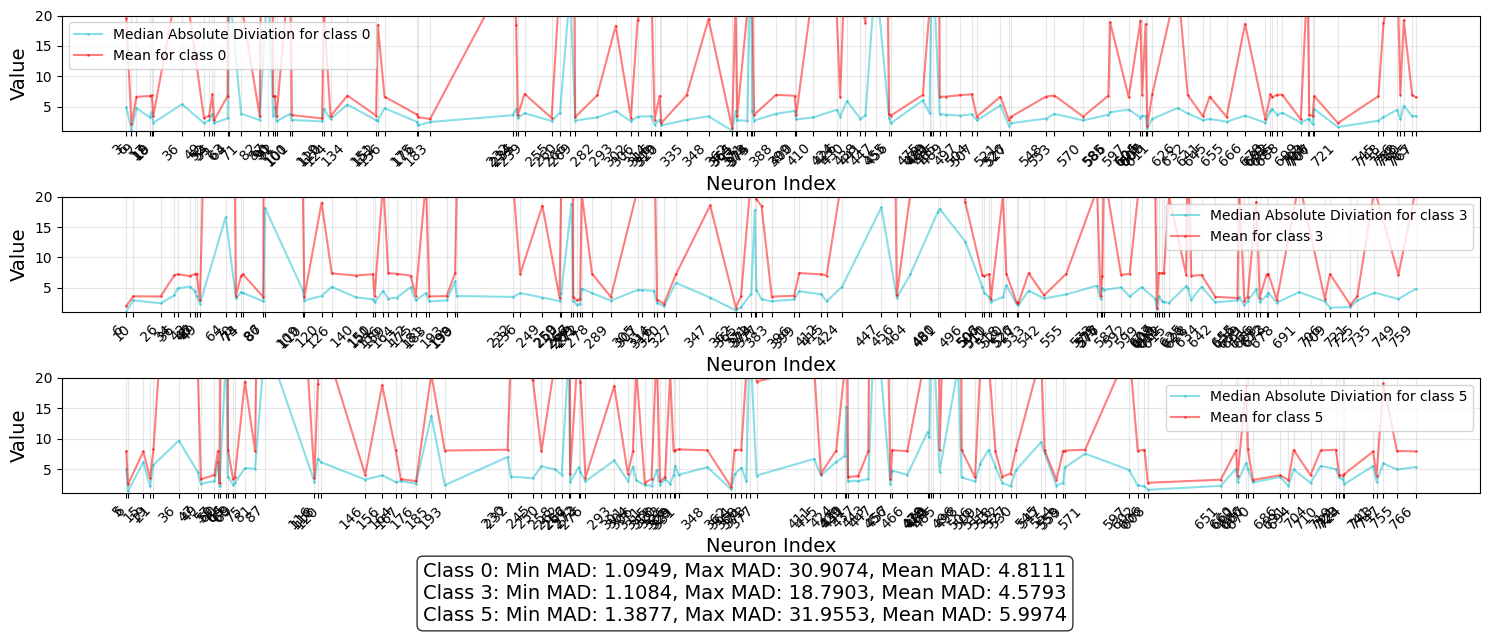

In [24]:
import numpy as np
import matplotlib.pyplot as plt

def mad(data):
    median = np.median(data, axis=0)
    deviations = np.abs(data - median)
    mad_value = np.median(deviations, axis=0)
    return mad_value

def z_score(data):
    
    #4200,768
    """
    Calculate z-scores along axis 0 (columns) of a 2D array.
    
    Parameters:
    data : numpy.ndarray
        2D input array where rows are observations and columns are features
        
    Returns:
    numpy.ndarray
        Array of same shape as input with z-scores calculated for each column
    """
    # Calculate mean along axis 0
    mean = np.mean(data, axis=0)
    
    #768
    
    # Calculate standard deviation along axis 0
    std = np.std(data, axis=0, ddof=1)  # ddof=1 for sample standard deviation
    
    # Avoid division by zero
    # std = np.where(std == 0, 1, std)
    
    # Calculate z-scores
    
    # 4200,768
    z_scores = (data - mean) / std
    z_scores = np.mean(z_scores, axis=0)
    
    return z_scores

def plot_class_statistics(all_fc_vals, plot_type='both', save_path=None):
    """
    Generate separate plots for each class showing variance and standard deviation.
    
    Args:
        all_fc_vals: List of numpy arrays, each of shape (n_samples, hidden_size)
        plot_type: 'both', 'variance', or 'std' to specify which metrics to plot
        save_path: Optional path to save the plot
    """
    num_classes = len(all_fc_vals)
    all_fc_vals = [np.array(fc_vals) for fc_vals in all_fc_vals]
    num_neurons = all_fc_vals[0].shape[1]
    
    # Calculate number of rows and columns for subplots
    n_rows = (num_classes + 2) // 1  # 3 plots per row
    n_cols = min(1, num_classes)
    
    # Create figure
    fig = plt.figure(figsize=(15, 2 * n_rows + 2))  # Added extra height for stats
    x = np.arange(num_neurons)

    # Color scheme
    colors = {
        'variance': '#1f77b4',  # Blue
        'std': '#17becf'        # Green
    }
    
    # Collect all statistics
    all_stats = []
    
    # Create subplots for each class
    i=0
    for class_idx, class_features in enumerate(all_fc_vals):
        
        if class_idx in [0,3,5]:
            
            ax = plt.subplot(n_rows, n_cols, i + 1)
            i+=1
            # Calculate statistics
            variance = np.var(class_features, axis=0)
            std_dev = mad(class_features)
            
            mean = np.mean(np.abs(class_features), axis=0)
            
            indices_top = np.argsort(mean)[:int(768*0.05)]
            
            indices_bottom = np.argsort(mean)[-int(768*0.05):]
            
            indices_middle = np.argsort(mean)[int(768*0.475):int(768*0.525)]
            
            selected_indices = np.concatenate([indices_top, indices_bottom, indices_middle])
            
            selected_indices.sort()
            
            std_dev = std_dev[selected_indices]
            
            variance = variance[selected_indices]
            
            mean = mean[selected_indices]
            
            xi = x[selected_indices]
            
            # Store statistics for later
            all_stats.append({
                'class': class_idx,
                'min_std': std_dev.min(),
                'max_std': std_dev.max(),
                'mean_std': std_dev.mean(),
                'min_var': variance.min(),
                'max_var': variance.max(),
                'mean_var': variance.mean()
            })
            
            if plot_type in ['both', 'variance']:
                ax.plot(xi, variance, 
                    label='Variance',
                    color=colors['variance'],
                    alpha=0.7,
                    linestyle='-')
                
            if plot_type in ['both', 'std']:
                ax.plot(xi, std_dev, 
                    label=f'Median Absolute Diviation for class {class_idx}',
                    color=colors['std'],
                    alpha=0.5,
                    linestyle='-',
                    marker='o',
                    markersize=1)
                ax.plot(xi, mean, 
                    label=f'Mean for class {class_idx}',
                    color='red',
                    alpha=0.5,
                    linestyle='-',
                    marker='o',
                    markersize=1)
            
            # Customize subplot
            # ax.set_title(f'Class {class_idx}')
            ax.set_xlabel('Neuron Index', fontsize=14)
            ax.set_ylabel('Value', fontsize=14)
            ax.legend()
            ax.grid(True, alpha=0.3)
            
            # Set y-axis limits if needed
            ax.set_ylim(1, 20)
            ax.set_xticks(xi)
            ax.set_xticklabels(xi, rotation=45, ha='right')

    # Create summary statistics text
    stats_text = []
    for stats in all_stats:
        stats_text.append(
            f"Class {stats['class']}: "
            f"Min MAD: {stats['min_std']:.4f}, "
            f"Max MAD: {stats['max_std']:.4f}, "
            f"Mean MAD: {stats['mean_std']:.4f}"
        )
    
    # Add combined statistics text box at the bottom
    summary_text = '\n'.join(stats_text)
    # flag = False
    # for text in stats_text:
    #     if flag:
    #         summary_text += text + '\n'
    #         flag = False
    #     else:
    #         summary_text += text + ','
    #         flag = True
            
    summary_text = summary_text.strip('\n')
        
    fig.text(0.5, 0.65, summary_text,
             ha='center',
             va='bottom',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8), fontsize=14)
    
    # Adjust layout
    plt.tight_layout()
    # Add padding at the bottom for stats
    plt.subplots_adjust(bottom=0.1 + 0.02*num_classes)  # Adjust based on number of classes
    
    # Save if path provided
    if save_path:
        plt.savefig(save_path, dpi=600, bbox_inches='tight', format='pdf')
        print(f"Plot saved to {save_path}")
    
    return fig, ax

# Example usage:
fig, ax = plot_class_statistics(all_fc_vals, plot_type='std', save_path='class_statistics.pdf')
plt.show()

Plot saved to class_statistics.pdf


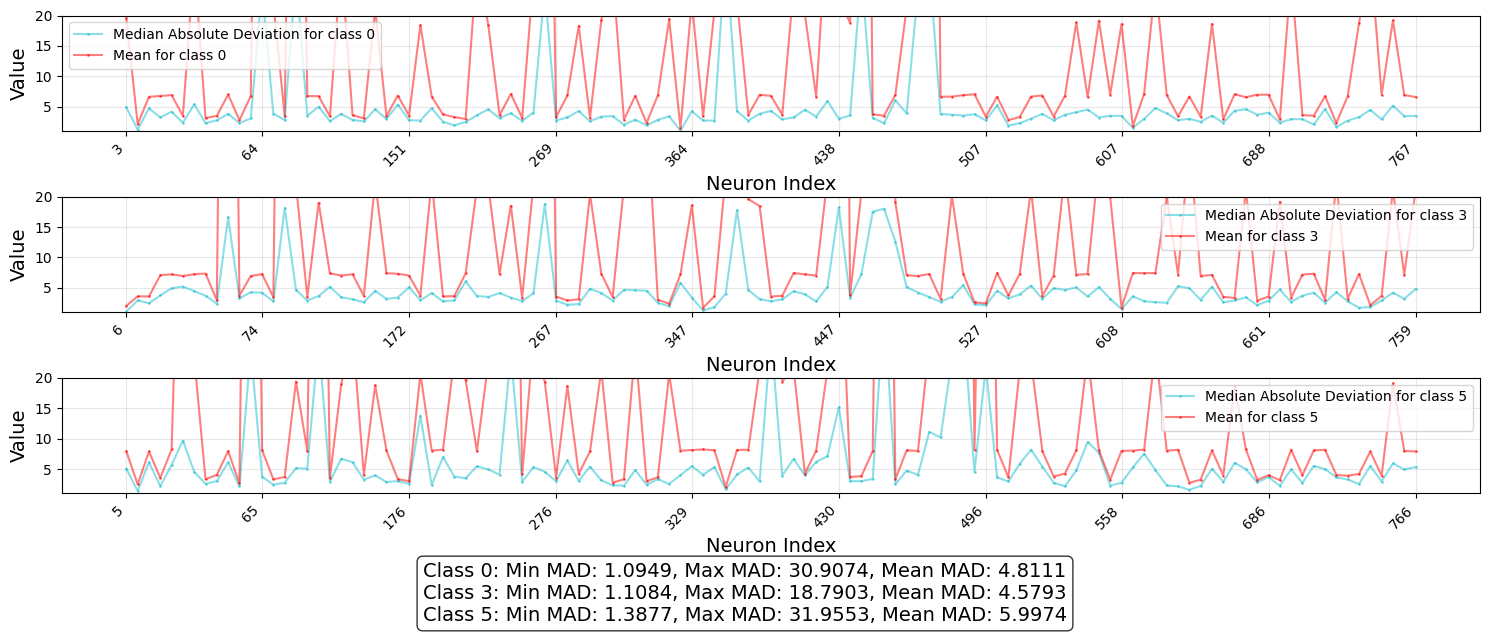

In [ ]:
def plot_class_statistics(all_fc_vals, plot_type='both', save_path=None):
    """
    Generate separate plots for each class showing variance and standard deviation.
    
    Args:
        all_fc_vals: List of numpy arrays, each of shape (n_samples, hidden_size)
        plot_type: 'both', 'variance', or 'std' to specify which metrics to plot
        save_path: Optional path to save the plot
    """
    num_classes = len(all_fc_vals)
    all_fc_vals = [np.array(fc_vals) for fc_vals in all_fc_vals]
    num_neurons = all_fc_vals[0].shape[1]
    
    # Calculate number of rows and columns for subplots
    n_rows = (num_classes + 2) // 1
    n_cols = min(1, num_classes)
    
    # Create figure
    fig = plt.figure(figsize=(15, 2 * n_rows + 2))
    x = np.arange(num_neurons)

    # Color scheme
    colors = {
        'variance': '#1f77b4',  # Blue
        'std': '#17becf'        # Green
    }
    
    # Collect all statistics
    all_stats = []
    
    # Create subplots for each class
    i = 0
    for class_idx, class_features in enumerate(all_fc_vals):
        if class_idx in [0, 3, 5]:
            ax = plt.subplot(n_rows, n_cols, i + 1)
            i += 1
            
            # Calculate statistics
            variance = np.var(class_features, axis=0)
            std_dev = mad(class_features)
            mean = np.mean(np.abs(class_features), axis=0)
            
            # Select indices for top, bottom, and middle portions
            indices_top = np.argsort(mean)[:int(768*0.05)]
            indices_bottom = np.argsort(mean)[-int(768*0.05):]
            indices_middle = np.argsort(mean)[int(768*0.475):int(768*0.525)]
            
            selected_indices = np.concatenate([indices_top, indices_bottom, indices_middle])
            selected_indices.sort()
            
            # Apply selection to statistics
            std_dev = std_dev[selected_indices]
            variance = variance[selected_indices]
            mean = mean[selected_indices]
            
            # Create evenly spaced x positions for plotting
            x_plot = np.arange(len(selected_indices))
            
            # Store statistics
            all_stats.append({
                'class': class_idx,
                'min_std': std_dev.min(),
                'max_std': std_dev.max(),
                'mean_std': std_dev.mean(),
                'min_var': variance.min(),
                'max_var': variance.max(),
                'mean_var': variance.mean()
            })
            
            if plot_type in ['both', 'variance']:
                ax.plot(x_plot, variance, 
                    label='Variance',
                    color=colors['variance'],
                    alpha=0.7,
                    linestyle='-')
                
            if plot_type in ['both', 'std']:
                ax.plot(x_plot, std_dev, 
                    label=f'Median Absolute Deviation for class {class_idx}',
                    color=colors['std'],
                    alpha=0.5,
                    linestyle='-',
                    marker='o',
                    markersize=1)
                ax.plot(x_plot, mean, 
                    label=f'Mean for class {class_idx}',
                    color='red',
                    alpha=0.5,
                    linestyle='-',
                    marker='o',
                    markersize=1)
            
            # Customize subplot
            ax.set_xlabel('Neuron Index', fontsize=14)
            ax.set_ylabel('Value', fontsize=14)
            ax.legend()
            ax.grid(True, alpha=0.3)
            
            # Set y-axis limits
            ax.set_ylim(1, 20)
            
            # Set evenly spaced x-ticks with original indices as labels
            num_ticks = min(10, len(selected_indices))  # Limit number of ticks for readability
            tick_positions = np.linspace(0, len(selected_indices)-1, num_ticks, dtype=int)
            ax.set_xticks(tick_positions)
            ax.set_xticklabels([selected_indices[pos] for pos in tick_positions],
                             rotation=45, ha='right')

    # Create summary statistics text
    stats_text = []
    for stats in all_stats:
        stats_text.append(
            f"Class {stats['class']}: "
            f"Min MAD: {stats['min_std']:.4f}, "
            f"Max MAD: {stats['max_std']:.4f}, "
            f"Mean MAD: {stats['mean_std']:.4f}"
        )
    
    # Add combined statistics text box
    summary_text = '\n'.join(stats_text)
    fig.text(0.5, 0.65, summary_text,
             ha='center',
             va='bottom',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8), 
             fontsize=14)
    
    # Adjust layout
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.1 + 0.02*num_classes)
    
    # Save if path provided
    if save_path:
        plt.savefig(save_path, dpi=600, bbox_inches='tight', format='pdf')
        print(f"Plot saved to {save_path}")
    
    return fig, ax

# Example usage:
fig, ax = plot_class_statistics(all_fc_vals, plot_type='std', save_path='class_statistics.pdf')
plt.show()

Plot saved to class_statistics.pdf


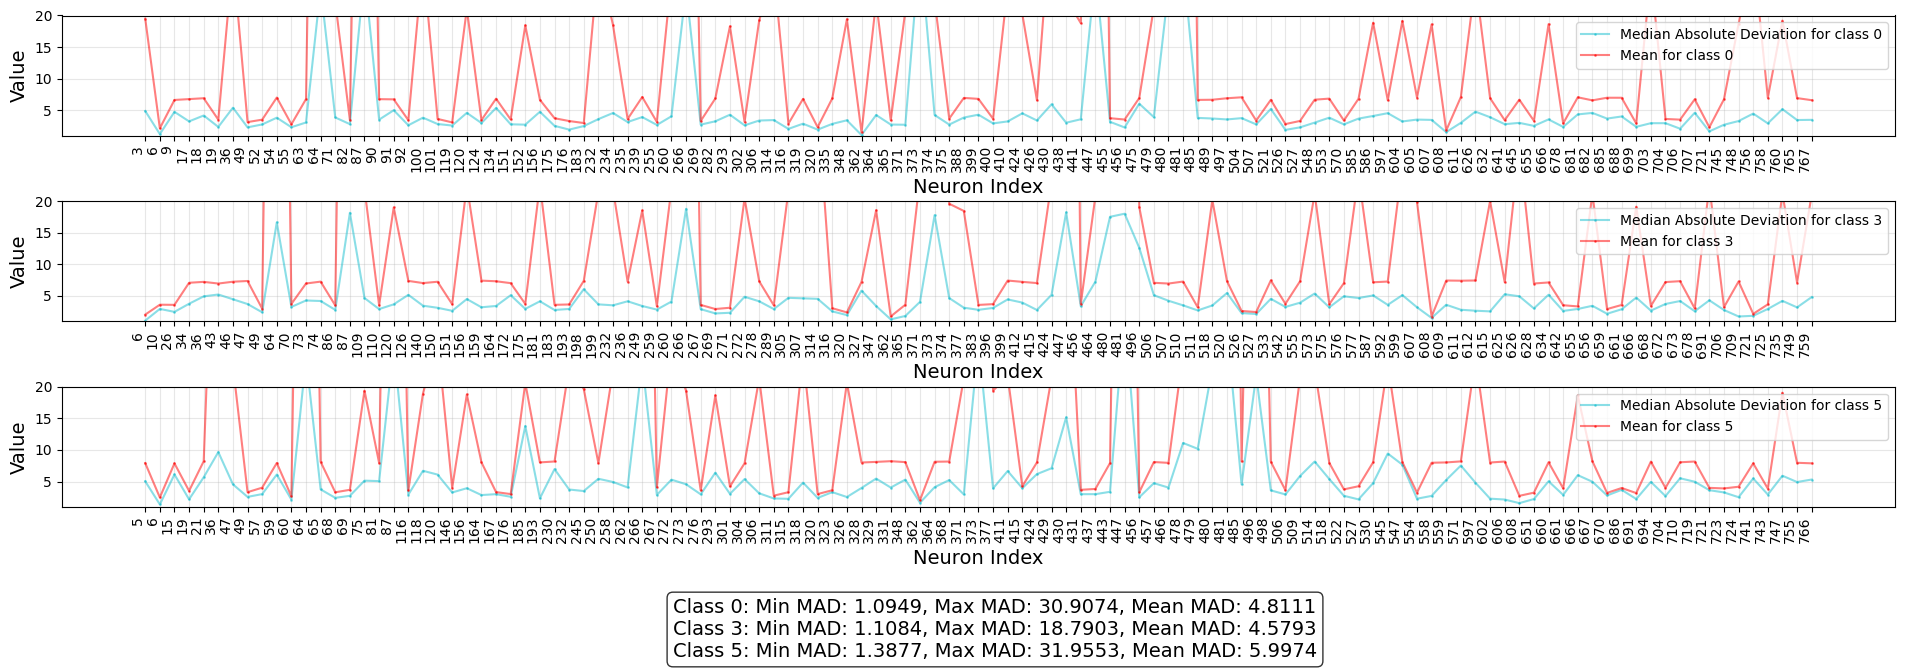

In [32]:
def plot_class_statistics(all_fc_vals, plot_type='both', save_path=None):
    """
    Generate separate plots for each class showing variance and standard deviation.
    
    Args:
        all_fc_vals: List of numpy arrays, each of shape (n_samples, hidden_size)
        plot_type: 'both', 'variance', or 'std' to specify which metrics to plot
        save_path: Optional path to save the plot
    """
    num_classes = len(all_fc_vals)
    all_fc_vals = [np.array(fc_vals) for fc_vals in all_fc_vals]
    num_neurons = all_fc_vals[0].shape[1]
    
    # Calculate number of rows and columns for subplots
    n_rows = (num_classes + 2) // 1
    n_cols = min(1, num_classes)
    
    # Create figure with increased width
    fig = plt.figure(figsize=(20, 2 * n_rows + 2))  # Increased width from 15 to 20
    x = np.arange(num_neurons)

    # Color scheme
    colors = {
        'variance': '#1f77b4',  # Blue
        'std': '#17becf'        # Green
    }
    
    # Collect all statistics
    all_stats = []
    
    # Create subplots for each class
    i = 0
    for class_idx, class_features in enumerate(all_fc_vals):
        if class_idx in [0, 3, 5]:
            ax = plt.subplot(n_rows, n_cols, i + 1)
            i += 1
            
            # Calculate statistics
            variance = np.var(class_features, axis=0)
            std_dev = mad(class_features)
            mean = np.mean(np.abs(class_features), axis=0)
            
            # Select indices for top, bottom, and middle portions
            indices_top = np.argsort(mean)[:int(768*0.05)]
            indices_bottom = np.argsort(mean)[-int(768*0.05):]
            indices_middle = np.argsort(mean)[int(768*0.475):int(768*0.525)]
            
            selected_indices = np.concatenate([indices_top, indices_bottom, indices_middle])
            selected_indices.sort()
            
            # Apply selection to statistics
            std_dev = std_dev[selected_indices]
            variance = variance[selected_indices]
            mean = mean[selected_indices]
            
            # Create evenly spaced x positions for plotting
            x_plot = np.arange(len(selected_indices))
            
            # Store statistics
            all_stats.append({
                'class': class_idx,
                'min_std': std_dev.min(),
                'max_std': std_dev.max(),
                'mean_std': std_dev.mean(),
                'min_var': variance.min(),
                'max_var': variance.max(),
                'mean_var': variance.mean()
            })
            
            if plot_type in ['both', 'variance']:
                ax.plot(x_plot, variance, 
                    label='Variance',
                    color=colors['variance'],
                    alpha=0.7,
                    linestyle='-')
                
            if plot_type in ['both', 'std']:
                ax.plot(x_plot, std_dev, 
                    label=f'Median Absolute Deviation for class {class_idx}',
                    color=colors['std'],
                    alpha=0.5,
                    linestyle='-',
                    marker='o',
                    markersize=1)
                ax.plot(x_plot, mean, 
                    label=f'Mean for class {class_idx}',
                    color='red',
                    alpha=0.5,
                    linestyle='-',
                    marker='o',
                    markersize=1)
            
            # Customize subplot
            ax.set_xlabel('Neuron Index', fontsize=14)
            ax.set_ylabel('Value', fontsize=14)
            ax.legend()
            ax.grid(True, alpha=0.3)
            
            # Set y-axis limits
            ax.set_ylim(1, 20)
            
            # Show all selected indices on x-axis
            ax.set_xticks(x_plot)
            ax.set_xticklabels(selected_indices, rotation=90, ha='right')
            
            # Adjust subplot to give more room for x-axis labels
            plt.subplots_adjust(bottom=0.2)

    # Create summary statistics text
    stats_text = []
    for stats in all_stats:
        stats_text.append(
            f"Class {stats['class']}: "
            f"Min MAD: {stats['min_std']:.4f}, "
            f"Max MAD: {stats['max_std']:.4f}, "
            f"Mean MAD: {stats['mean_std']:.4f}"
        )
    
    # Add combined statistics text box
    summary_text = '\n'.join(stats_text)
    fig.text(0.5, 0.63, summary_text,
             ha='center',
             va='bottom',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8), 
             fontsize=14)
    
    # Adjust layout
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.2, right=0.95)  # Increased bottom margin for labels
    
    # Save if path provided
    if save_path:
        plt.savefig(save_path, dpi=600, bbox_inches='tight', format='pdf')
        print(f"Plot saved to {save_path}")
    
    return fig, ax

fig, ax = plot_class_statistics(all_fc_vals, plot_type='std', save_path='class_statistics.pdf')
plt.show()

Plot saved to class_statistics.pdf


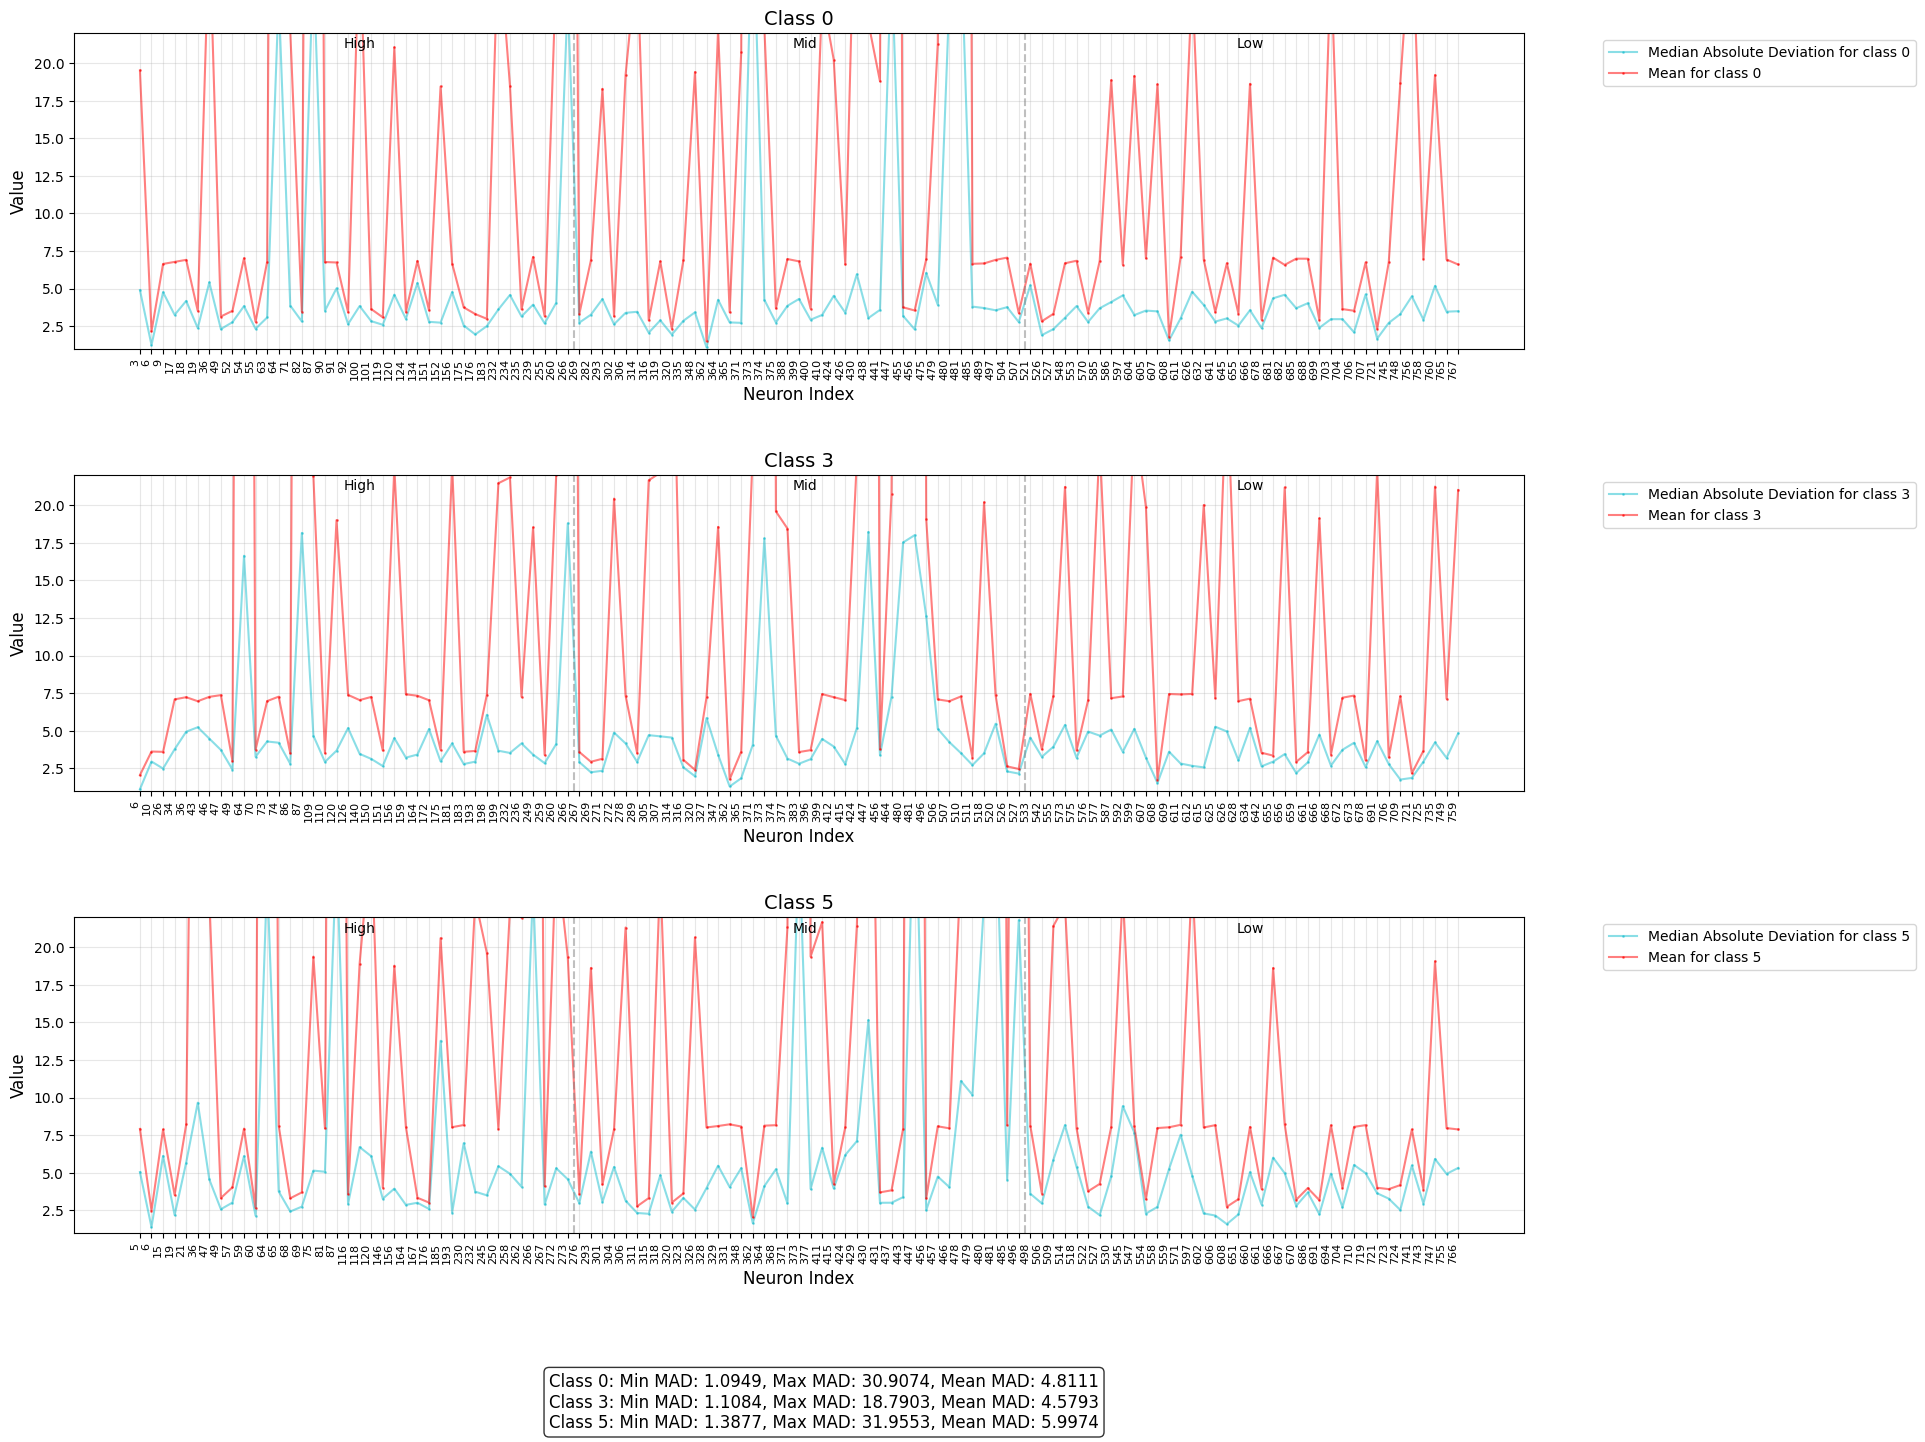

In [35]:
def plot_class_statistics(all_fc_vals, plot_type='both', save_path=None):
    """
    Generate separate plots for each class showing variance and standard deviation.
    
    Args:
        all_fc_vals: List of numpy arrays, each of shape (n_samples, hidden_size)
        plot_type: 'both', 'variance', or 'std' to specify which metrics to plot
        save_path: Optional path to save the plot
    """
    num_classes = len(all_fc_vals)
    all_fc_vals = [np.array(fc_vals) for fc_vals in all_fc_vals]
    num_neurons = all_fc_vals[0].shape[1]
    
    # Create figure
    fig = plt.figure(figsize=(20, 15))  # Increased height
    
    # Color scheme
    colors = {
        'variance': '#1f77b4',  # Blue
        'std': '#17becf'        # Green
    }
    
    # Collect all statistics
    all_stats = []
    
    # Create subplots for each class
    i = 0
    for class_idx, class_features in enumerate(all_fc_vals):
        if class_idx in [0, 3, 5]:
            ax = plt.subplot(3, 1, i + 1)  # Changed to 3,1 for better spacing
            i += 1
            
            # Calculate statistics
            variance = np.var(class_features, axis=0)
            std_dev = mad(class_features)
            mean = np.mean(np.abs(class_features), axis=0)
            
            # Select indices for top, bottom, and middle portions
            indices_top = np.argsort(mean)[:int(768*0.05)]
            indices_bottom = np.argsort(mean)[-int(768*0.05):]
            indices_middle = np.argsort(mean)[int(768*0.475):int(768*0.525)]
            
            selected_indices = np.concatenate([indices_top, indices_bottom, indices_middle])
            selected_indices.sort()
            
            # Apply selection to statistics
            std_dev = std_dev[selected_indices]
            variance = variance[selected_indices]
            mean = mean[selected_indices]
            
            # Create evenly spaced x positions for plotting
            x_plot = np.arange(len(selected_indices))
            
            # Find positions for dividers
            high_end = len(indices_top)
            mid_start = high_end
            mid_end = high_end + len(indices_middle)
            
            # Store statistics
            all_stats.append({
                'class': class_idx,
                'min_std': std_dev.min(),
                'max_std': std_dev.max(),
                'mean_std': std_dev.mean(),
                'min_var': variance.min(),
                'max_var': variance.max(),
                'mean_var': variance.mean()
            })
            
            if plot_type in ['both', 'variance']:
                ax.plot(x_plot, variance, 
                    label='Variance',
                    color=colors['variance'],
                    alpha=0.7,
                    linestyle='-')
                
            if plot_type in ['both', 'std']:
                ax.plot(x_plot, std_dev, 
                    label=f'Median Absolute Deviation for class {class_idx}',
                    color=colors['std'],
                    alpha=0.5,
                    linestyle='-',
                    marker='o',
                    markersize=1)
                ax.plot(x_plot, mean, 
                    label=f'Mean for class {class_idx}',
                    color='red',
                    alpha=0.5,
                    linestyle='-',
                    marker='o',
                    markersize=1)
            
            # Add vertical dividers
            ax.axvline(x=high_end - 0.5, color='gray', linestyle='--', alpha=0.5)
            ax.axvline(x=mid_end - 0.5, color='gray', linestyle='--', alpha=0.5)
            
            # Add region labels
            ax.text(high_end/2, 21, 'High', ha='center')
            ax.text((mid_start + mid_end)/2, 21, 'Mid', ha='center')
            ax.text((mid_end + len(selected_indices))/2, 21, 'Low', ha='center')
            
            # Customize subplot
            ax.set_xlabel('Neuron Index', fontsize=12)
            ax.set_ylabel('Value', fontsize=12)
            ax.set_title(f'Class {class_idx}', fontsize=14)
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            ax.grid(True, alpha=0.3)
            
            # Set y-axis limits with extra space for labels
            ax.set_ylim(1, 22)  # Increased to make room for labels
            
            # Show all selected indices on x-axis
            ax.set_xticks(x_plot)
            ax.set_xticklabels(selected_indices, rotation=90, ha='right', fontsize=8)

    # Create summary statistics text
    stats_text = []
    for stats in all_stats:
        stats_text.append(
            f"Class {stats['class']}: "
            f"Min MAD: {stats['min_std']:.4f}, "
            f"Max MAD: {stats['max_std']:.4f}, "
            f"Mean MAD: {stats['mean_std']:.4f}"
        )
    
    # Add combined statistics text box at the bottom
    plt.figtext(0.5, 0.02, '\n'.join(stats_text),
                ha='center',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                fontsize=12)
    
    # Adjust layout
    plt.subplots_adjust(right=0.85,  # Make room for legend
                       bottom=0.15,   # Make room for stats text
                       top=0.95,      # Reduce top margin
                       hspace=0.4)    # Add space between subplots
    
    # Save if path provided
    if save_path:
        plt.savefig(save_path, dpi=600, bbox_inches='tight', format='pdf')
        print(f"Plot saved to {save_path}")
    
    return fig, ax

fig, ax = plot_class_statistics(all_fc_vals, plot_type='std', save_path='class_statistics.pdf')
plt.show()

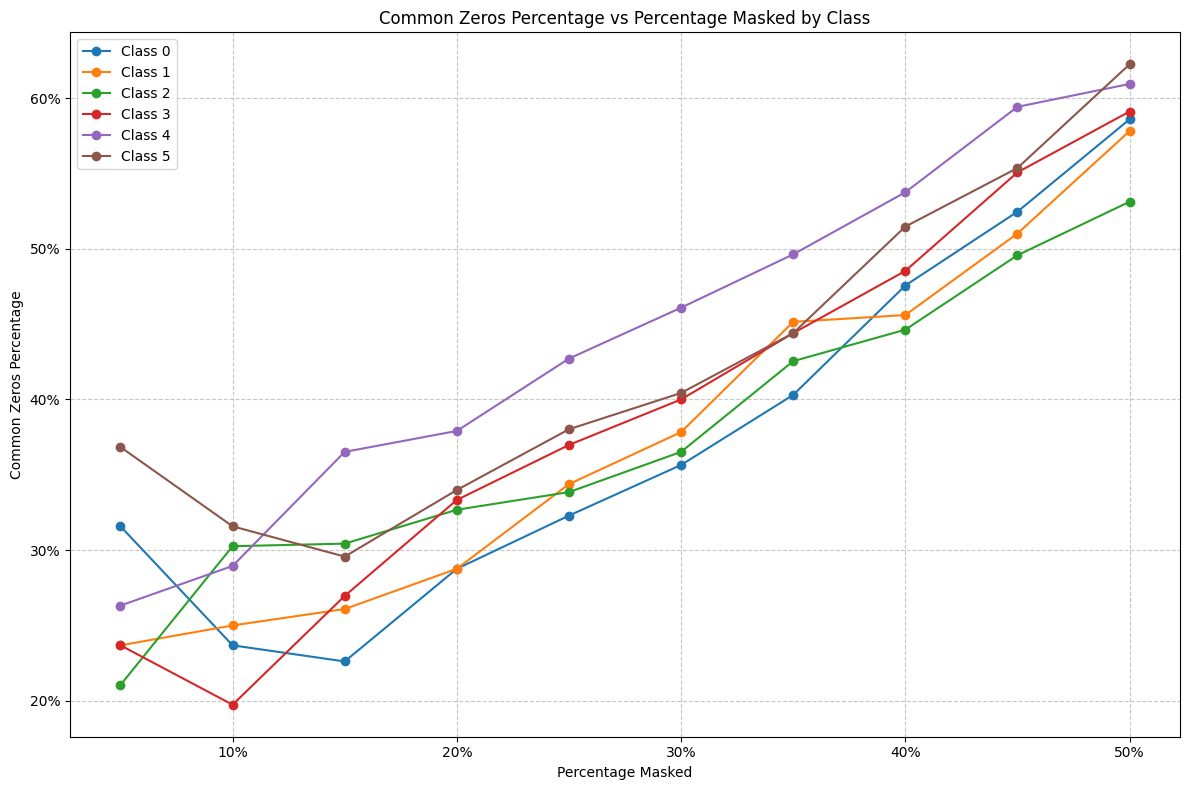

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import re

# Function to extract data from text
def extract_data(text):
    # Initialize lists to store data
    percentages = []
    classes = []
    common_zeros_percentages = []
    
    # Extract data using regular expressions
    current_percentage = None
    for line in text.split('\n'):
        # Get percentage from header
        if "Analysis for Percentage:" in line:
            current_percentage = float(re.search(r"(\d+\.\d+)", line).group(1))
        
        # Get class data from table rows
        if re.match(r"\|\s*\d+\s*\|", line):
            parts = line.split('|')
            if len(parts) >= 5:
                class_num = int(parts[1].strip())
                common_zeros_pct = float(parts[4].strip())
                
                percentages.append(current_percentage)
                classes.append(class_num)
                common_zeros_percentages.append(common_zeros_pct)
    
    # Create DataFrame
    df = pd.DataFrame({
        'Percentage_Masked': percentages,
        'Class': classes,
        'Common_Zeros_Percentage': common_zeros_percentages
    })
    
    return df

# Create the visualization
def plot_data(df):
    plt.figure(figsize=(12, 8))
    
    # Plot line for each class
    for class_num in sorted(df['Class'].unique()):
        class_data = df[df['Class'] == class_num]
        plt.plot(
            class_data['Percentage_Masked'],
            class_data['Common_Zeros_Percentage'],
            marker='o',
            label=f'Class {class_num}'
        )
    
    plt.xlabel('Percentage Masked')
    plt.ylabel('Common Zeros Percentage')
    plt.title('Common Zeros Percentage vs Percentage Masked by Class')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    
    # Convert x-axis to percentage format
    plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0%}'))
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0%}'))
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    
    return plt

# Example usage
# Assuming your text is stored in a variable called 'text':
text = '''Analysis for Percentage: 0.05
+-------+--------------+--------------+----------------+
| Class | Total Masked | Common Zeros | Common Zeros % |
+-------+--------------+--------------+----------------+
|   0   |      38      |      12      |     0.3158     |
|   1   |      38      |      9       |     0.2368     |
|   2   |      38      |      8       |     0.2105     |
|   3   |      38      |      9       |     0.2368     |
|   4   |      38      |      10      |     0.2632     |
|   5   |      38      |      14      |     0.3684     |
+-------+--------------+--------------+----------------+
--------------------------------------------------

Analysis for Percentage: 0.10
+-------+--------------+--------------+----------------+
| Class | Total Masked | Common Zeros | Common Zeros % |
+-------+--------------+--------------+----------------+
|   0   |      76      |      18      |     0.2368     |
|   1   |      76      |      19      |     0.2500     |
|   2   |      76      |      23      |     0.3026     |
|   3   |      76      |      15      |     0.1974     |
|   4   |      76      |      22      |     0.2895     |
|   5   |      76      |      24      |     0.3158     |
+-------+--------------+--------------+----------------+
--------------------------------------------------

Analysis for Percentage: 0.15
+-------+--------------+--------------+----------------+
| Class | Total Masked | Common Zeros | Common Zeros % |
+-------+--------------+--------------+----------------+
|   0   |     115      |      26      |     0.2261     |
|   1   |     115      |      30      |     0.2609     |
|   2   |     115      |      35      |     0.3043     |
|   3   |     115      |      31      |     0.2696     |
|   4   |     115      |      42      |     0.3652     |
|   5   |     115      |      34      |     0.2957     |
+-------+--------------+--------------+----------------+
--------------------------------------------------

Analysis for Percentage: 0.20
+-------+--------------+--------------+----------------+
| Class | Total Masked | Common Zeros | Common Zeros % |
+-------+--------------+--------------+----------------+
|   0   |     153      |      44      |     0.2876     |
|   1   |     153      |      44      |     0.2876     |
|   2   |     153      |      50      |     0.3268     |
|   3   |     153      |      51      |     0.3333     |
|   4   |     153      |      58      |     0.3791     |
|   5   |     153      |      52      |     0.3399     |
+-------+--------------+--------------+----------------+
--------------------------------------------------

Analysis for Percentage: 0.25
+-------+--------------+--------------+----------------+
| Class | Total Masked | Common Zeros | Common Zeros % |
+-------+--------------+--------------+----------------+
|   0   |     192      |      62      |     0.3229     |
|   1   |     192      |      66      |     0.3438     |
|   2   |     192      |      65      |     0.3385     |
|   3   |     192      |      71      |     0.3698     |
|   4   |     192      |      82      |     0.4271     |
|   5   |     192      |      73      |     0.3802     |
+-------+--------------+--------------+----------------+
--------------------------------------------------

Analysis for Percentage: 0.30
+-------+--------------+--------------+----------------+
| Class | Total Masked | Common Zeros | Common Zeros % |
+-------+--------------+--------------+----------------+
|   0   |     230      |      82      |     0.3565     |
|   1   |     230      |      87      |     0.3783     |
|   2   |     230      |      84      |     0.3652     |
|   3   |     230      |      92      |     0.4000     |
|   4   |     230      |     106      |     0.4609     |
|   5   |     230      |      93      |     0.4043     |
+-------+--------------+--------------+----------------+
--------------------------------------------------

Analysis for Percentage: 0.35
+-------+--------------+--------------+----------------+
| Class | Total Masked | Common Zeros | Common Zeros % |
+-------+--------------+--------------+----------------+
|   0   |     268      |     108      |     0.4030     |
|   1   |     268      |     121      |     0.4515     |
|   2   |     268      |     114      |     0.4254     |
|   3   |     268      |     119      |     0.4440     |
|   4   |     268      |     133      |     0.4963     |
|   5   |     268      |     119      |     0.4440     |
+-------+--------------+--------------+----------------+
--------------------------------------------------

Analysis for Percentage: 0.40
+-------+--------------+--------------+----------------+
| Class | Total Masked | Common Zeros | Common Zeros % |
+-------+--------------+--------------+----------------+
|   0   |     307      |     146      |     0.4756     |
|   1   |     307      |     140      |     0.4560     |
|   2   |     307      |     137      |     0.4463     |
|   3   |     307      |     149      |     0.4853     |
|   4   |     307      |     165      |     0.5375     |
|   5   |     307      |     158      |     0.5147     |
+-------+--------------+--------------+----------------+
--------------------------------------------------

Analysis for Percentage: 0.45
+-------+--------------+--------------+----------------+
| Class | Total Masked | Common Zeros | Common Zeros % |
+-------+--------------+--------------+----------------+
|   0   |     345      |     181      |     0.5246     |
|   1   |     345      |     176      |     0.5101     |
|   2   |     345      |     171      |     0.4957     |
|   3   |     345      |     190      |     0.5507     |
|   4   |     345      |     205      |     0.5942     |
|   5   |     345      |     191      |     0.5536     |
+-------+--------------+--------------+----------------+
--------------------------------------------------

Analysis for Percentage: 0.50
+-------+--------------+--------------+----------------+
| Class | Total Masked | Common Zeros | Common Zeros % |
+-------+--------------+--------------+----------------+
|   0   |     384      |     225      |     0.5859     |
|   1   |     384      |     222      |     0.5781     |
|   2   |     384      |     204      |     0.5312     |
|   3   |     384      |     227      |     0.5911     |
|   4   |     384      |     234      |     0.6094     |
|   5   |     384      |     239      |     0.6224     |
+-------+--------------+--------------+----------------+
--------------------------------------------------
'''


df = extract_data(text)
plt = plot_data(df)
plt.show()


Spearman Correlation Results:
  Class  Spearman Correlation      P-Value
Class 0              0.915152 2.044724e-04
Class 1              1.000000 6.646897e-64
Class 2              1.000000 6.646897e-64
Class 3              0.987879 9.307460e-08
Class 4              1.000000 6.646897e-64
Class 5              0.915152 2.044724e-04


<Figure size 640x480 with 0 Axes>

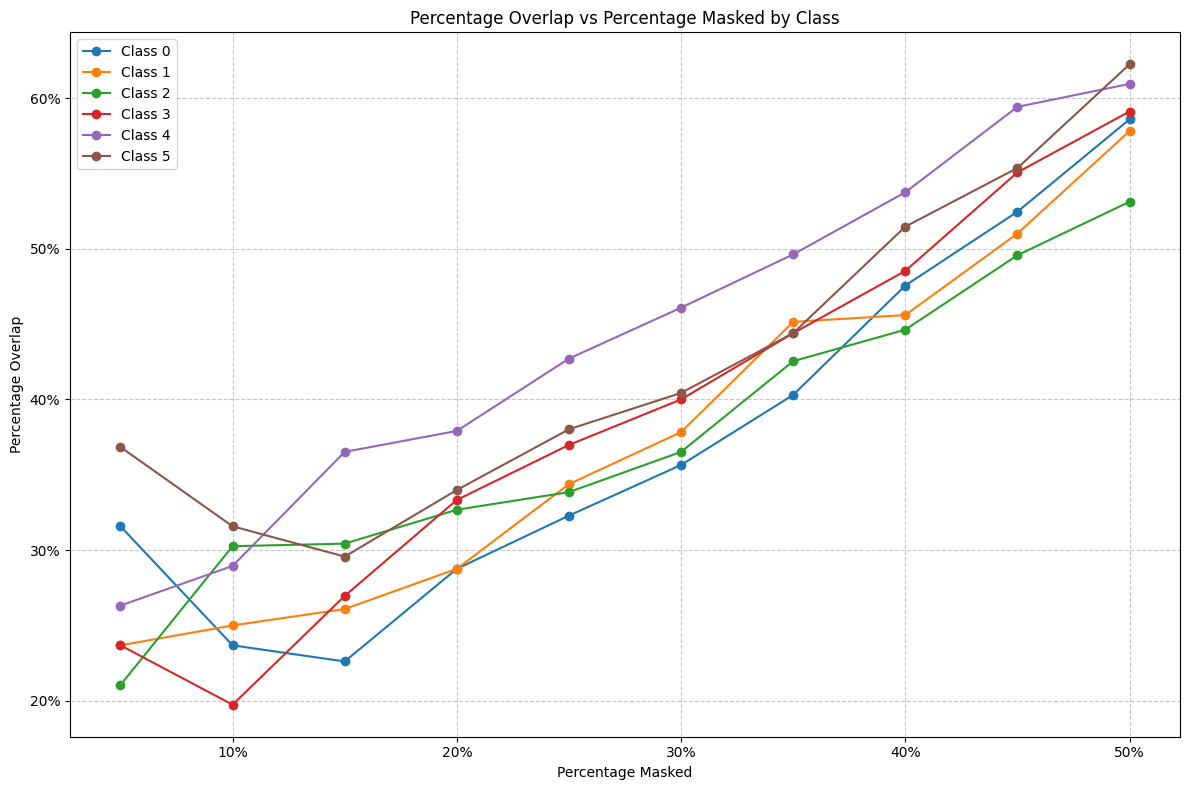

<Figure size 640x480 with 0 Axes>

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import re
from scipy import stats
import seaborn as sns
import numpy as np

# Function to extract data from text
def extract_data(text):
    # Initialize lists to store data
    percentages = []
    classes = []
    common_zeros_percentages = []
    
    # Extract data using regular expressions
    current_percentage = None
    for line in text.split('\n'):
        # Get percentage from header
        if "Analysis for Percentage:" in line:
            current_percentage = float(re.search(r"(\d+\.\d+)", line).group(1))
        
        # Get class data from table rows
        if re.match(r"\|\s*\d+\s*\|", line):
            parts = line.split('|')
            if len(parts) >= 5:
                class_num = int(parts[1].strip())
                common_zeros_pct = float(parts[4].strip())
                
                percentages.append(current_percentage)
                classes.append(class_num)
                common_zeros_percentages.append(common_zeros_pct)
    
    # Create DataFrame
    df = pd.DataFrame({
        'Percentage_Masked': percentages,
        'Class': classes,
        'Common_Zeros_Percentage': common_zeros_percentages
    })
    
    return df

# Create the visualization
def plot_data(df):
    plt.figure(figsize=(12, 8))
    
    # Plot line for each class
    for class_num in sorted(df['Class'].unique()):
        class_data = df[df['Class'] == class_num]
        plt.plot(
            class_data['Percentage_Masked'],
            class_data['Common_Zeros_Percentage'],
            marker='o',
            label=f'Class {class_num}'
        )
    
    plt.xlabel('Percentage Masked')
    plt.ylabel('Percentage Overlap')
    plt.title('Percentage Overlap vs Percentage Masked by Class')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    
    # Convert x-axis to percentage format
    plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0%}'))
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0%}'))
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    
    return plt

def calculate_spearman_correlation(df):
    # Calculate Spearman correlation for each class
    correlations = {}
    p_values = {}
    
    for class_num in sorted(df['Class'].unique()):
        class_data = df[df['Class'] == class_num]
        correlation, p_value = stats.spearmanr(
            class_data['Percentage_Masked'],
            class_data['Common_Zeros_Percentage']
        )
        correlations[f'Class {class_num}'] = correlation
        p_values[f'Class {class_num}'] = p_value
    
    # Create correlation DataFrame
    correlation_df = pd.DataFrame({
        'Class': list(correlations.keys()),
        'Spearman Correlation': list(correlations.values()),
        'P-Value': list(p_values.values())
    })
    
    return correlation_df

def plot_correlation_heatmap(df):
    # Pivot the data to create a correlation matrix
    pivot_df = df.pivot(index='Class', columns='Percentage_Masked', values='Common_Zeros_Percentage')
    
    # Calculate correlation matrix
    corr_matrix = pivot_df.corr(method='spearman')
    
    # Create heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
    plt.title('Spearman Correlation Heatmap between Classes')
    plt.tight_layout()
    
    return plt

# Example usage
# Assuming your text is stored in a variable called 'text':
df = extract_data(text)

# Calculate and display Spearman correlations
correlation_results = calculate_spearman_correlation(df)
print("\nSpearman Correlation Results:")
print(correlation_results.to_string(index=False))

# Create visualizations
plot_data(df)
plt.savefig('common_zeros_plot.pdf', dpi=600, bbox_inches='tight', format='pdf')
plt.figure()
# plot_correlation_heatmap(df)
# plt.show()


Spearman Correlation between Percentage Masked and Overlap Percentage:
Correlation coefficient: 0.9299
P-value: 7.1850e-27


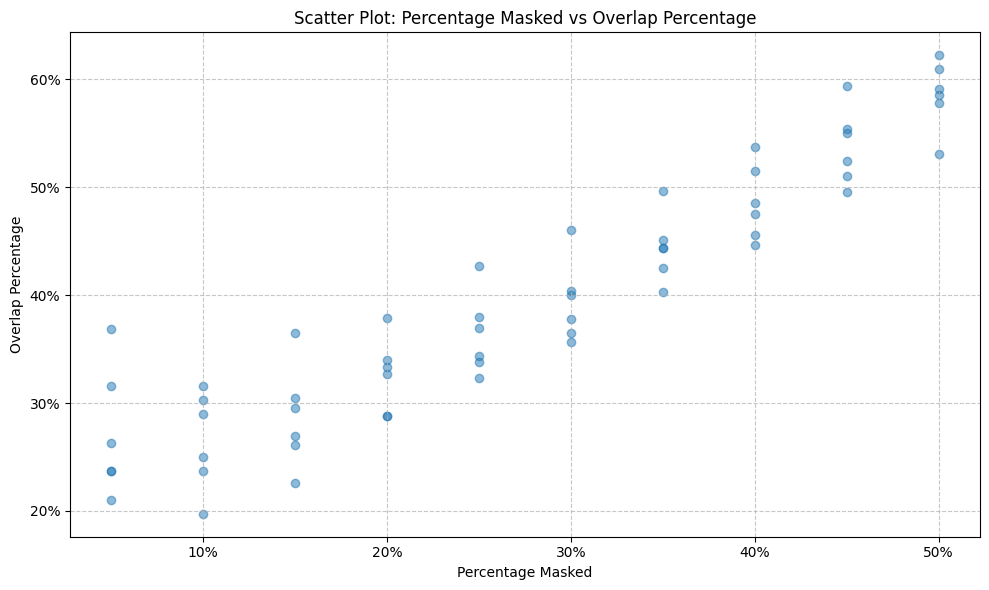

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import re

def extract_data(text):
    # Initialize lists to store data
    percentages = []
    common_zeros_percentages = []
    
    # Extract data using regular expressions
    current_percentage = None
    for line in text.split('\n'):
        # Get percentage from header
        if "Analysis for Percentage:" in line:
            current_percentage = float(re.search(r"(\d+\.\d+)", line).group(1))
        
        # Get class data from table rows
        if re.match(r"\|\s*\d+\s*\|", line):
            parts = line.split('|')
            if len(parts) >= 5:
                common_zeros_pct = float(parts[4].strip())
                
                percentages.append(current_percentage)
                common_zeros_percentages.append(common_zeros_pct)
    
    return percentages, common_zeros_percentages

def calculate_correlation(text):
    # Get data
    percentages, common_zeros_percentages = extract_data(text)
    
    # Calculate Spearman correlation
    correlation, p_value = stats.spearmanr(percentages, common_zeros_percentages)
    
    # Print results
    print(f"\nSpearman Correlation between Percentage Masked and Overlap Percentage:")
    print(f"Correlation coefficient: {correlation:.4f}")
    print(f"P-value: {p_value:.4e}")
    
    # Create scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(percentages, common_zeros_percentages, alpha=0.5)
    plt.xlabel('Percentage Masked')
    plt.ylabel('Overlap Percentage')
    plt.title('Scatter Plot: Percentage Masked vs Overlap Percentage')
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Convert axes to percentage format
    plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0%}'))
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0%}'))
    
    plt.tight_layout()
    plt.show()

# Run analysis
calculate_correlation(text)